***
# W4: NLP Disaster Tweets
***

This project is a submission to [this Kaggle competition](https://www.kaggle.com/competitions/nlp-getting-started/overview) about classifying tweets related to disasters.

Tweets, using informal language, are difficult to classify with machine learning algorithms. Being able to monitor tweets automatically can be very helpful to organizations to report news and send support for disasters. This project is about designing and training a machine learning model that can accurately classify whether any tweet is referring to a real disaster or not.

This is an NLP binary classification problem. I will be training a Recurrent Neural Network to solve this challenge.

The training dataset consists of 7,503 record. Each record consists of keywords, a location, the text of the tweet, and the classification (target).

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional
from tensorflow.keras.regularizers import l2

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

%matplotlib inline

***
# Data Exploration and Cleaning
***

In [2]:
raw_data = pd.read_csv('./data/train.csv')
raw_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print(f"Dataset shape: {raw_data.shape}")
print(f"\nColumn data types:")
print(raw_data.dtypes)
print(f"\nBasic statistics:")
print(raw_data.describe())

Dataset shape: (7613, 5)

Column data types:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Basic statistics:
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


Data types are correct.

In [4]:
missing_data = raw_data.isnull().sum()
missing_percent = (missing_data / len(raw_data)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

          Missing Count  Missing Percentage
location           2533           33.272035
keyword              61            0.801261


As the dataset page mentions, there are many records with missing location and/or keyword values. The amount of missing keywords is very low, but about 33% of records are missing a location.

Target distribution:
Non-disaster (0): 4342 (57.0%)
Disaster (1): 3271 (43.0%)


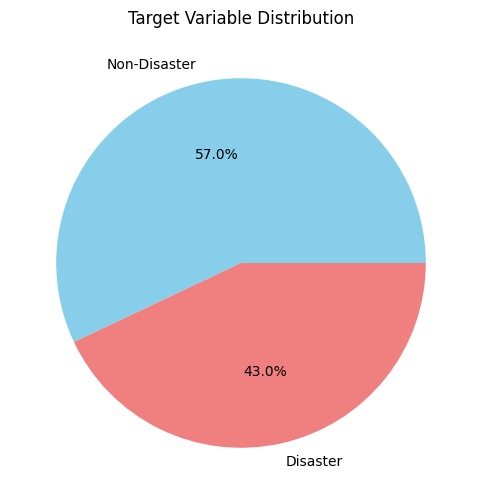

In [5]:
target_counts = raw_data['target'].value_counts()
print(f"Target distribution:")
print(f"Non-disaster (0): {target_counts[0]} ({target_counts[0]/len(raw_data)*100:.1f}%)")
print(f"Disaster (1): {target_counts[1]} ({target_counts[1]/len(raw_data)*100:.1f}%)")

plt.figure(figsize=(8, 6))
plt.pie(target_counts.values, labels=['Non-Disaster', 'Disaster'], 
        autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Target Variable Distribution')
plt.show()

There is a slight class imbalance, but it is not very storng. This likely won't need to be addressed.

## Features

### Word/character Counts

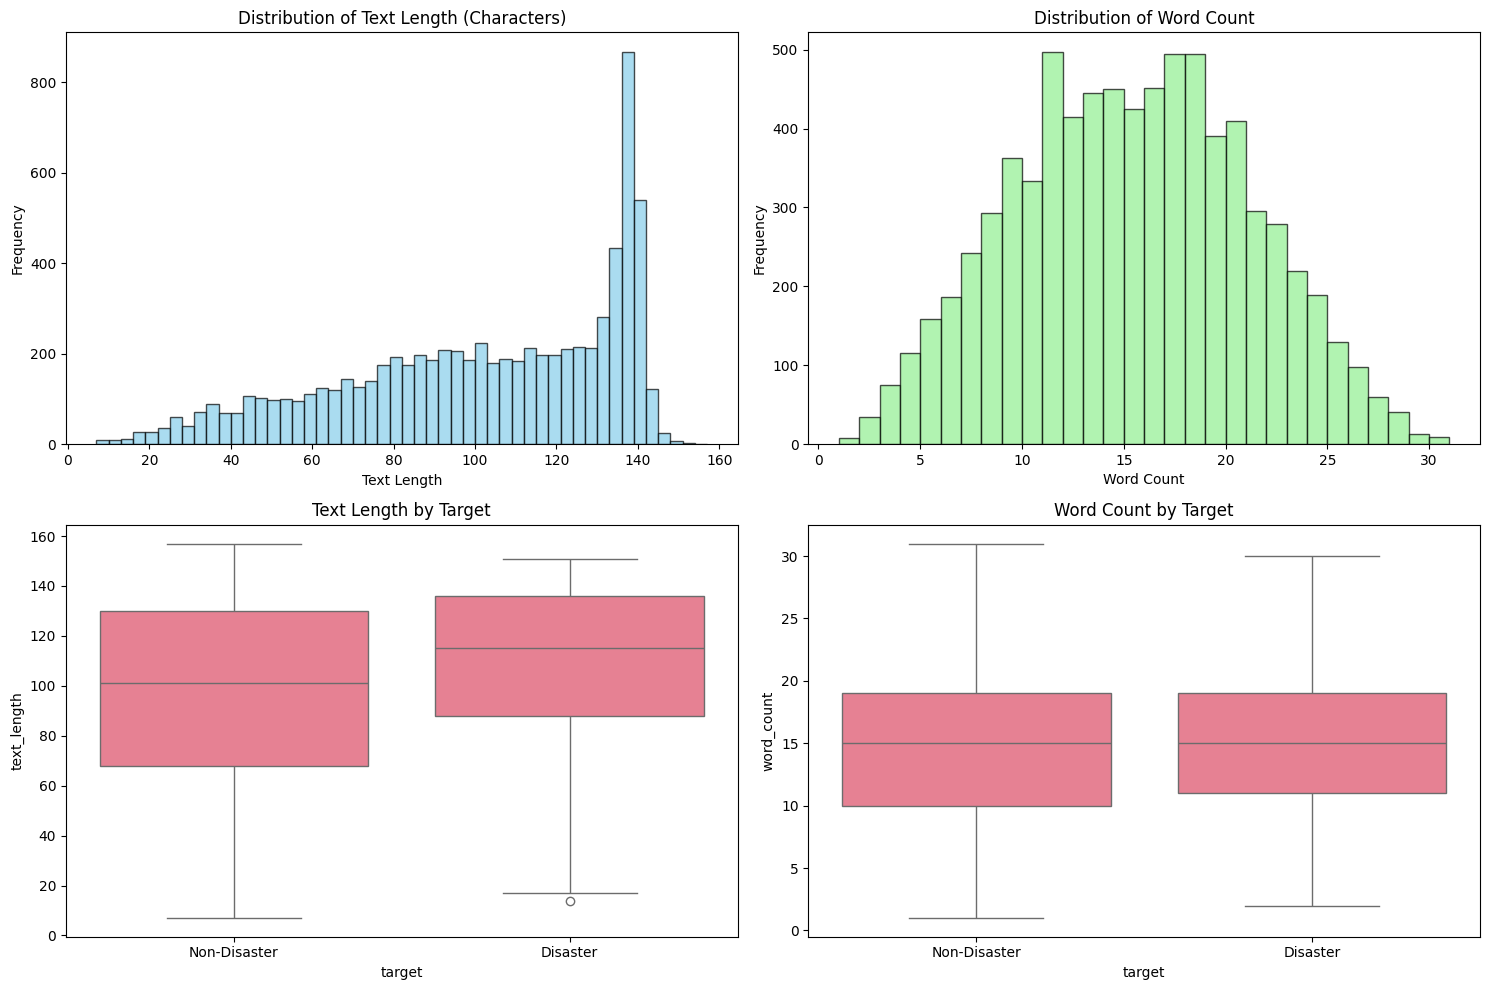


Text length comparison by target:
         count        mean        std   min   25%    50%    75%    max
target                                                                
0       4342.0   95.706817  35.885924   7.0  68.0  101.0  130.0  157.0
1       3271.0  108.113421  29.309854  14.0  88.0  115.0  136.0  151.0

Word count comparison by target:
         count       mean       std  min   25%   50%   75%   max
target                                                          
0       4342.0  14.704744  6.161564  1.0  10.0  15.0  19.0  31.0
1       3271.0  15.167533  5.096806  2.0  11.0  15.0  19.0  30.0


In [6]:
raw_data['text_length'] = raw_data['text'].apply(len)
raw_data['word_count'] = raw_data['text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].hist(raw_data['text_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Text Length (Characters)')
axes[0,0].set_xlabel('Text Length')
axes[0,0].set_ylabel('Frequency')

axes[0,1].hist(raw_data['word_count'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Distribution of Word Count')
axes[0,1].set_xlabel('Word Count')
axes[0,1].set_ylabel('Frequency')

sns.boxplot(data=raw_data, x='target', y='text_length', ax=axes[1,0])
axes[1,0].set_title('Text Length by Target')
axes[1,0].set_xticklabels(['Non-Disaster', 'Disaster'])

sns.boxplot(data=raw_data, x='target', y='word_count', ax=axes[1,1])
axes[1,1].set_title('Word Count by Target')
axes[1,1].set_xticklabels(['Non-Disaster', 'Disaster'])

plt.tight_layout()
plt.show()

print(f"\nText length comparison by target:")
print(raw_data.groupby('target')['text_length'].describe())
print(f"\nWord count comparison by target:")
print(raw_data.groupby('target')['word_count'].describe())

raw_data = raw_data.drop(columns=['text_length', 'word_count'])

The text length varies from 7 - 157 characters, averaging at around 100. The word count ranges from 1 - 31 words, averaging around 15 words.

There is not a significant difference in word counts between disaster and non-disaster tweets, but disaster tweets tend to have slightly longer text length. This could potentially be a new feature to add to the dataset.

In [7]:
raw_data['keyword'] = raw_data['keyword'].str.replace('%20', ' ', regex=False)

I noticed that some keywords had a '%20' inside of them instead of a space. This is because of URL encodings, likely because the data was scraped from URLs. I made a quick edit to replace this with spaces.

### Keywords

Records without keywords: 61 (0.8%)


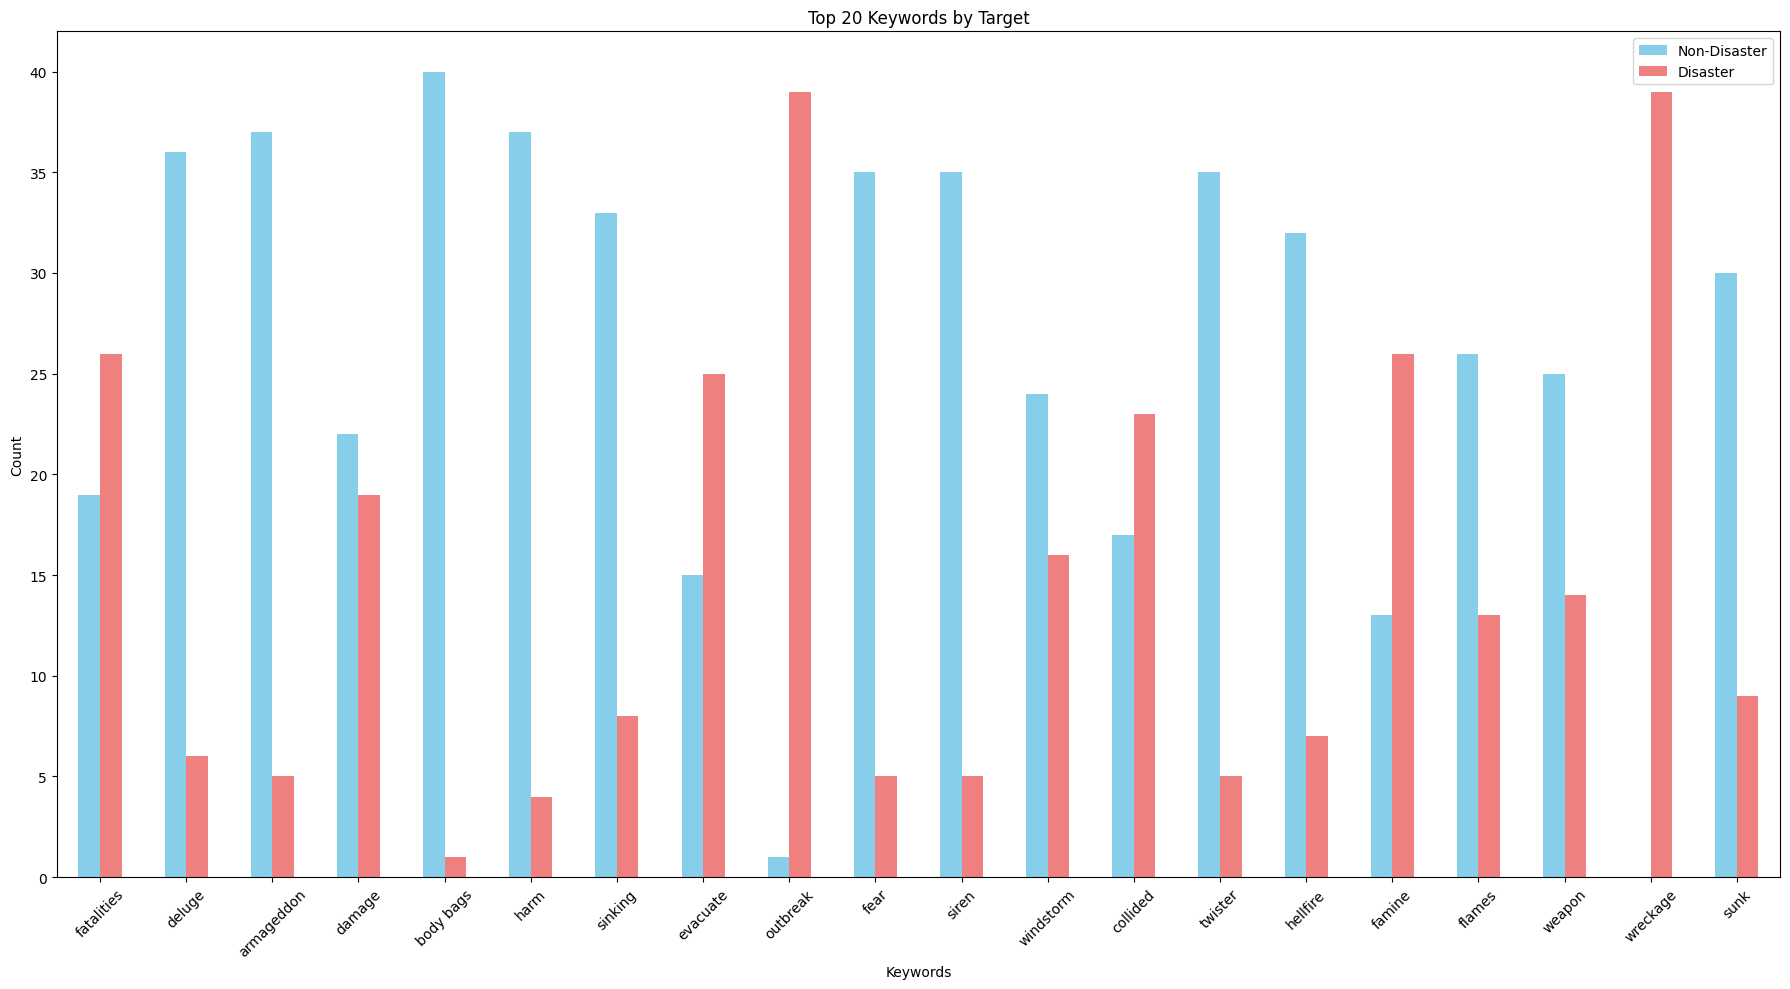

In [8]:
keywords_present = raw_data['keyword'].notna().sum()
total_records = len(raw_data)
print(f"Records without keywords: {total_records - keywords_present} ({(total_records - keywords_present)/total_records*100:.1f}%)")

keyword_counts = raw_data['keyword'].value_counts().head(20)
keyword_target = raw_data.groupby(['keyword', 'target']).size().unstack(fill_value=0)
keyword_target_top = keyword_target.loc[keyword_counts.index[:20]]

keyword_target_top.plot(kind='bar', figsize=(18, 10), color=['skyblue', 'lightcoral'])
plt.title('Top 20 Keywords by Target')
plt.xlabel('Keywords')
plt.ylabel('Count')
plt.legend(['Non-Disaster', 'Disaster'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The difference in frequencies for the top twenty keywords indicates that this will be a key feature in differentiating between the two classes. Since the amount of records with no keyword was so little (only 61), I decided to just fill it with blank strings.

In [9]:
raw_data['keyword'] = raw_data['keyword'].fillna('')

### Locations

Records without locations: 2533 (33.3%)

Percentage of tweets with locations:
Non-disaster: 66.4%
Disaster: 67.1%


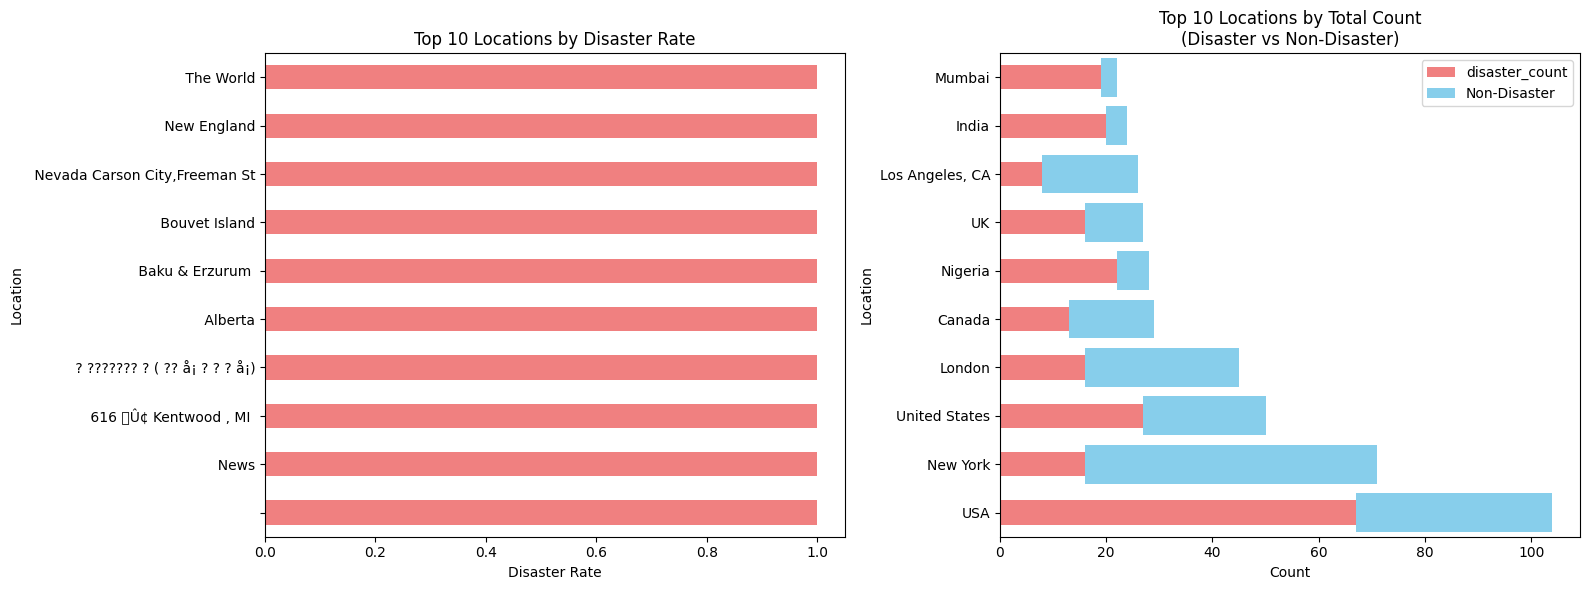

In [10]:
locations_present = raw_data['location'].notna().sum()
total_records = len(raw_data)
print(f"Records without locations: {total_records - locations_present} ({(total_records - locations_present)/total_records*100:.1f}%)")

location_by_target = raw_data.groupby('target')['location'].apply(lambda x: x.notna().sum())
total_by_target = raw_data['target'].value_counts()
location_pct_by_target = (location_by_target / total_by_target * 100)
print(f"\nPercentage of tweets with locations:")
print(f"Non-disaster: {location_pct_by_target[0]:.1f}%")
print(f"Disaster: {location_pct_by_target[1]:.1f}%")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

location_disaster_analysis = raw_data[raw_data['location'].notna()].groupby('location').agg({
    'target': ['count', 'sum', 'mean']
}).round(3)
location_disaster_analysis.columns = ['total_count', 'disaster_count', 'disaster_rate']

top_disaster_locations = location_disaster_analysis.nlargest(10, 'disaster_rate')
top_disaster_locations['disaster_rate'].plot(kind='barh', ax=axes[0], color='lightcoral')
axes[0].set_title('Top 10 Locations by Disaster Rate')
axes[0].set_xlabel('Disaster Rate')
axes[0].set_ylabel('Location')

top_locations_overall = location_disaster_analysis.nlargest(10, 'total_count')
top_locations_overall[['disaster_count']].plot(kind='barh', ax=axes[1], 
                                              color='lightcoral', label='Disaster')
non_disaster_count = top_locations_overall['total_count'] - top_locations_overall['disaster_count']
axes[1].barh(range(len(top_locations_overall)), non_disaster_count, 
               left=top_locations_overall['disaster_count'], color='skyblue', label='Non-Disaster')

axes[1].set_title('Top 10 Locations by Total Count\n(Disaster vs Non-Disaster)')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Location')
axes[1].legend()

plt.tight_layout()
plt.show()

In [11]:
unique_locations = raw_data['location'].nunique()
total_locations = raw_data['location'].notna().sum()
print(f"Number of unique locations: {unique_locations}")
print(f"Total records with location data: {total_locations}")
print(f"Percentage of unique locations: {unique_locations/total_locations*100:.2f}%")

Number of unique locations: 3341
Total records with location data: 5080
Percentage of unique locations: 65.77%


About 33% of the records had missing locations, evenly spread across the two classes. The locations are also user generated, which means that there is no standardization between locations. This is likely why there are so many unique locations (65%). 

Of the top locations, the percentage of disaster tweets varies a little, but not enough to be very significant. The highest frequency is only about 100.

The first plot also shows that the rate of disasters in locations can be 1 very frequently, especially because of how many unique locations there are.

Because of the dirtiness of this feature, I decided to remove it from the dataset.

In [12]:
train_data = raw_data.drop(columns=['location'])

In [13]:
train_data.head()

,id,keyword,text,target
0,1,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,Forest fire near La Ronge Sask. Canada,1
2,5,,All residents asked to 'shelter in place' are ...,1
3,6,,"13,000 people receive #wildfires evacuation or...",1
4,7,,Just got sent this photo from Ruby #Alaska as ...,1


### Cleaning and Engineering Summary So Far:

- removed location feature
- cleaned some URL encodings (will be expanded on below)
- filled missing keywords with empty strings

## Preprocessing

In order to keep the RNN model simple and using sequential text data, I ended up only using the text feature of each tweet (even after all that cleaning/exploration).

RNNs are specialized for sequential data, like sentences or tweets. The keyword feature would add some extra non-sequential data that would require a much more complicated architecture to handle.

I first needed to do some basic text cleaning, such as dealing with URLs, hashtags, etc.

In [14]:
def clean_text(text):
    text = re.sub(r'http\S+', 'url', text) # replaces URLs with 'url'
    text = re.sub(r'#(\w+)', r' hashtag \1 ', text) # replaces hashtags with 'hashtag' followed by the tag
    text = re.sub(r'@(\w+)', r' mention \1 ', text) # replaces mentions with 'mention' followed by the username
    text = re.sub(r'[^a-zA-Z0-9\s!?.]', '', text) # removes special characters except for !, ?, and .
    text = re.sub(r'\s+', ' ', text).strip() # cleans excess whitespace
    return text

In [15]:
print("#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires")
print(f"Cleaned: {clean_text('#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires')}")

#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
Cleaned: hashtag RockyFire Update California Hwy. 20 closed in both directions due to Lake County fire hashtag CAfire hashtag wildfires


In [16]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

train_data['text_clean'] = train_data['text'].apply(clean_text)
test_data['text_clean'] = test_data['text'].apply(clean_text)

I then used Keras's basic Tokenizer to tokenize the data. This tokenizer just assigns an index to each word. It's very basic, but it allows for the text data to remain in order without becoming a giant sparse matrix of tokenized words.

In [17]:
MAX_VOCAB_SIZE = 30000  # maximum vocabulary size
MAX_SEQUENCE_LENGTH = 50  # maximum tweet length

# Create tokenizer for text
text_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token="<OOV>",
    lower=True
)

all_texts = list(train_data['text_clean']) + list(test_data['text_clean'])
text_tokenizer.fit_on_texts(all_texts)

train_text_sequences = text_tokenizer.texts_to_sequences(train_data['text_clean'])
test_text_sequences = text_tokenizer.texts_to_sequences(test_data['text_clean'])
# padding sequences to same length
X_train_seq = pad_sequences(train_text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_seq = pad_sequences(test_text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [18]:
print(f"Vocab size: {len(text_tokenizer.word_index)}")

Vocab size: 22125


In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_seq, train_data['target'].values, test_size=0.2, random_state=42, stratify=train_data['target'].values
)

### Plan of Analysis

The competition is judged based on f1-score, so that is the primary metric I will use to judge the performance of my models. However, other metrics like AUC-ROC and loss will also be used to determine what needs to be tuned in the models.

***
# Modelling
***

My modelling approach involved trying 3 different types of RNN types from keras.

I started with a SimpleRNN as a baseline, without much tuning. I then moved onto an LSTM and Bidirectional LSTM.

The architecture for each model started simply, with 2 layers of RNNS, 1 dense layer, and an output layer. I used two RNN layers so that the model may be able to recognize more complicated patterns in the data, similar to how multiple convolution layers are used in CNNs. I did not want to overcomplicate it, as tweets are generally pretty short in length.

L2 regularization was also used to prevent overfitting on the data, by penalizing large weights. This prevents the model from being too skewed by certain inputs that may be more common in the training data. Dropout and recurrent dropout were also used to prevent overfitting.

I also used an early stopping callback to prevent the training from continuing unneccessarily.

Below are the base hyperparameters I started with, including learning rate, batch size, and output size for the embedding layer (the layer that converts the integer inputs from the tokenized text into a matrix with trainable weights).

In [20]:
LEARNING_RATE = 0.0001
METRICS = ['accuracy', 'Precision', 'Recall', 'AUC']
EMB_DIM = 128
BATCH_SIZE = 32

#### Functions

In [46]:
early_stopping_rnn = EarlyStopping(
    monitor='val_accuracy',
    patience=4,
    restore_best_weights=True,
    verbose=1,
    start_from_epoch=7
)

vocab_size = min(MAX_VOCAB_SIZE, len(text_tokenizer.word_index)) + 1

def compile_fit(model, training_epochs=50,early_stopping=True):
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=METRICS
    )

    return model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=training_epochs,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping_rnn] if early_stopping else [],
        verbose=1
    ).history

In [22]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    epochs = range(1, len(history['loss']) + 1)
    
    # loss
    axes[0, 0].plot(epochs, history['loss'], label='Training Loss', color='blue', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], label='Validation Loss', color='red', linewidth=2)
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xticks(epochs)
    
    # accuracy
    axes[0, 1].plot(epochs, history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
    axes[0, 1].plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xticks(epochs)
    
    # f1 score
    train_precision = np.array(history['Precision'])
    train_recall = np.array(history['Recall'])
    val_precision = np.array(history['val_Precision'])
    val_recall = np.array(history['val_Recall'])
    train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall + 1e-7) # prevents division by zero
    val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-7)
    
    axes[1, 0].plot(epochs, train_f1, label='Training F1 Score', color='blue', linewidth=2)
    axes[1, 0].plot(epochs, val_f1, label='Validation F1 Score', color='red', linewidth=2)
    axes[1, 0].set_title('Model F1 Score')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xticks(epochs)
    
    # AUC-ROC
    axes[1, 1].plot(epochs, history['AUC'], label='Training AUC', color='blue', linewidth=2)
    axes[1, 1].plot(epochs, history['val_AUC'], label='Validation AUC', color='red', linewidth=2)
    axes[1, 1].set_title('Model AUC-ROC')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('AUC')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xticks(epochs)
    
    plt.tight_layout()
    plt.show()

    print(f"Learning Rate: {LEARNING_RATE}")
    print(f"Embedding Dimension: {EMB_DIM}")
    print(f"Batch Size: {BATCH_SIZE}")

    print("\nResults:")
    print(f"Loss: {history['val_loss'][-1]:.4f}")
    print(f"Accuracy: {history['val_accuracy'][-1]:.4f}")
    print(f"Training F1 Score: {train_f1[-1]:.4f}")
    print(f"Validation F1 Score: {val_f1[-1]:.4f}")

## SimpleRNN

The SimpleRNN is literally a simple RNN that has the most basic structure of memory from previous timesteps. It does not have good long term memory. I only used this model as a baseline for comparing performance, and didn't do any tuning.

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - AUC: 0.5075 - Precision: 0.4139 - Recall: 0.1139 - accuracy: 0.5499 - loss: 0.7105 - val_AUC: 0.5094 - val_Precision: 0.4650 - val_Recall: 0.1728 - val_accuracy: 0.5594 - val_loss: 0.7031
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - AUC: 0.5022 - Precision: 0.4272 - Recall: 0.1334 - accuracy: 0.5507 - loss: 0.7082 - val_AUC: 0.5286 - val_Precision: 0.5000 - val_Recall: 0.0015 - val_accuracy: 0.5706 - val_loss: 0.6988
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - AUC: 0.4998 - Precision: 0.4397 - Recall: 0.1421 - accuracy: 0.5535 - loss: 0.7071 - val_AUC: 0.5475 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6980
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - AUC: 0.5124 - Precision: 0.4804 - Recall: 0.1169 - accuracy: 0.5662 - loss: 0.7027 - val_AUC: 0.5481 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6975
Epoch 5/50
1

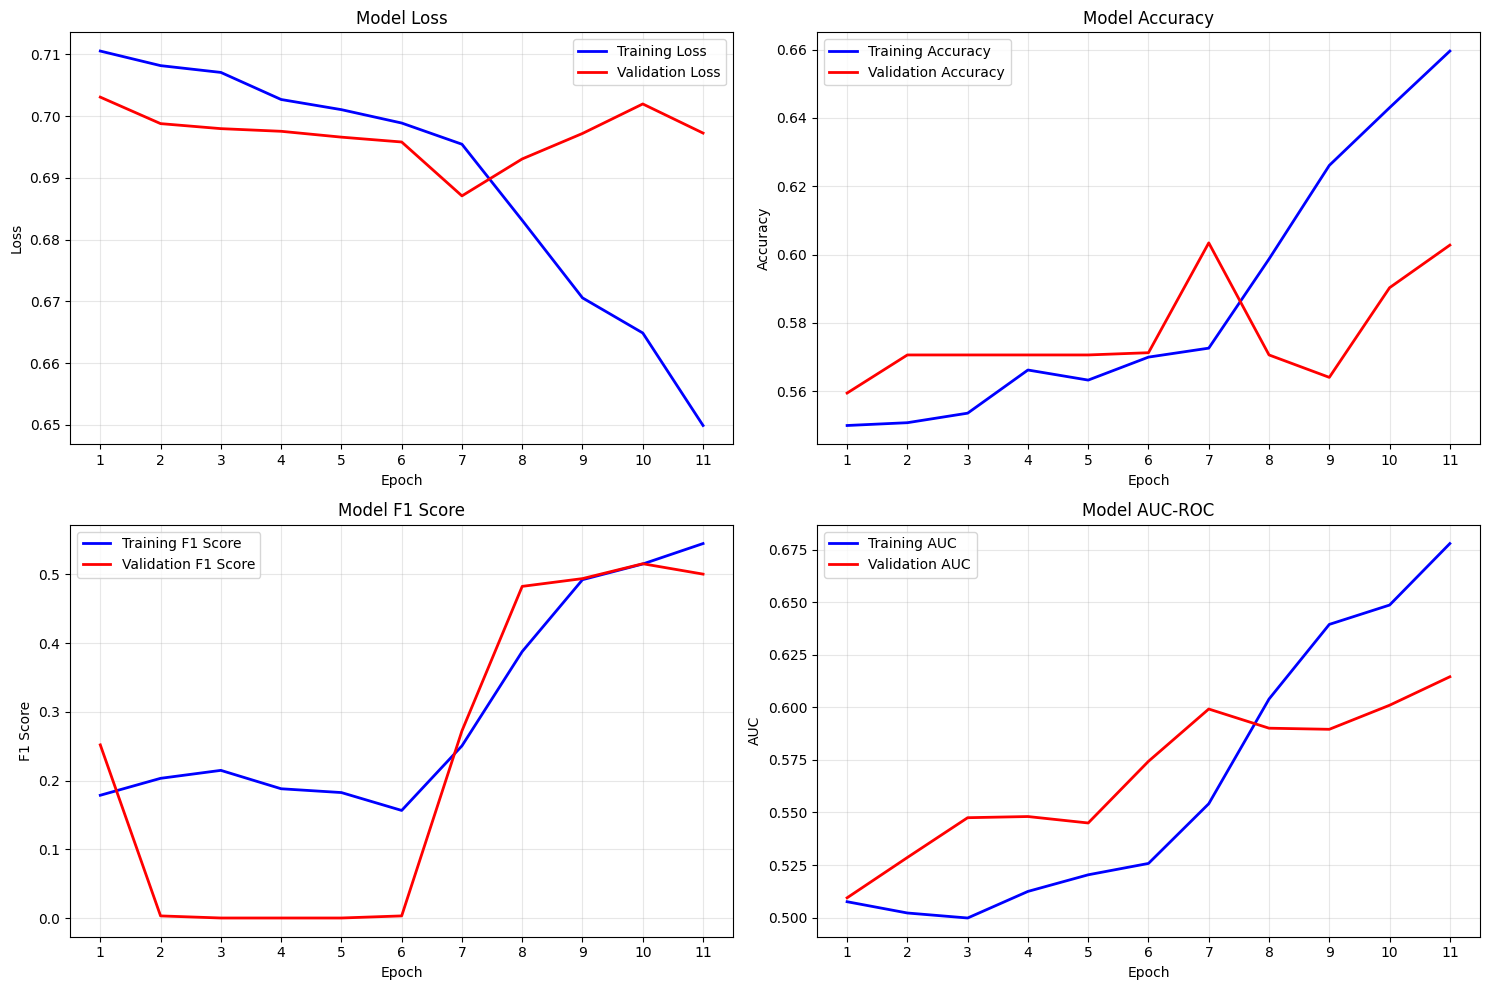

Learning Rate: 0.0001
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.6972
Accuracy: 0.6028
Training F1 Score: 0.5449
Validation F1 Score: 0.5004


In [29]:
rnn1 = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH, name='text_embedding'),
    
    SimpleRNN(64, recurrent_dropout=0.1, return_sequences=True, 
              kernel_regularizer=l2(0.0001)),
    SimpleRNN(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=False, 
              kernel_regularizer=l2(0.0001)),
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

hist_rnn1 = compile_fit(rnn1)
plot_training_history(hist_rnn1)

This model's performance was quite poor, as expected.

## LSTM

An LSTM (Long Short-Term Memory) RNN has a more complicated structure for retaining long term memory. In addition to short term memory, it has additional gates to remember older information.

In [30]:
lstm_hists = []
lstm_models = []

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 0.4851 - Precision: 0.3714 - Recall: 0.0099 - accuracy: 0.5673 - loss: 0.7172 - val_AUC: 0.5363 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7104
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 0.5013 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7080 - val_AUC: 0.4811 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7055
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4951 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7039 - val_AUC: 0.5002 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7016
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 0.6946 - Precision: 0.8137 - Recall: 0.2537 - accuracy: 0.6544 - loss: 0.6357 - val_AUC: 0.8259 - val_Precision: 0.7341 - val_Recall: 0.6881 - val_accuracy: 0.7590 - val_

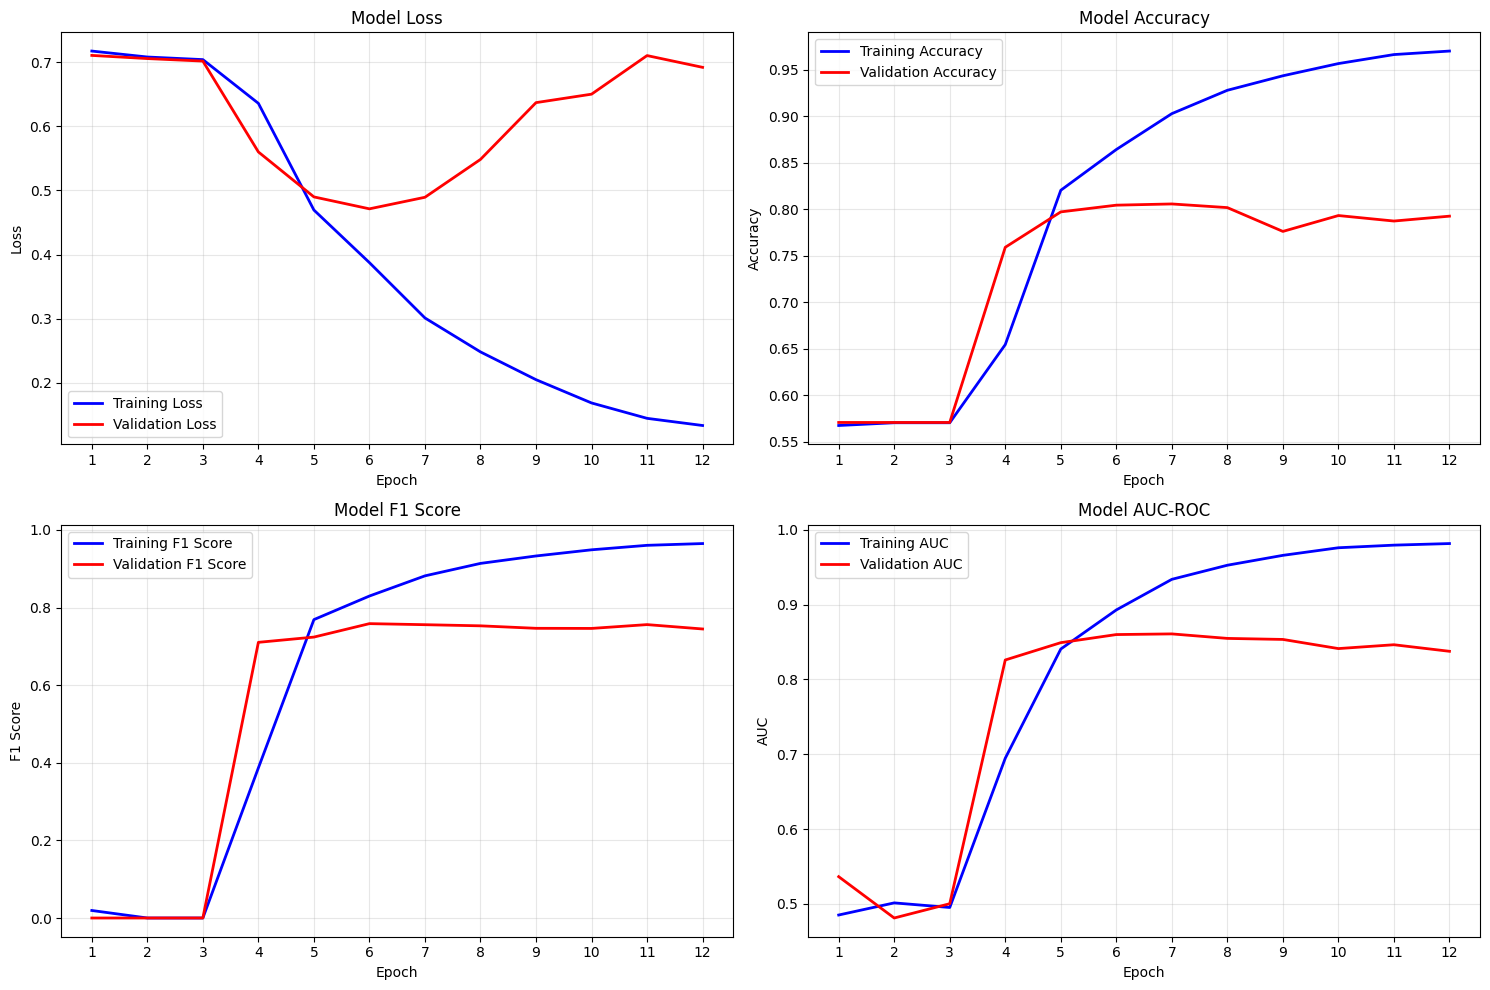

Learning Rate: 0.0001
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.6918
Accuracy: 0.7925
Training F1 Score: 0.9649
Validation F1 Score: 0.7447


In [31]:
LEARNING_RATE = 0.0001
EMB_DIM = 128
BATCH_SIZE = 32

lstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    LSTM(64, recurrent_dropout=0.1, return_sequences=True, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    LSTM(32, recurrent_dropout=0.1, dropout=0.1, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

hist_lstm = compile_fit(lstm)
plot_training_history(hist_lstm)

lstm_hists.append(hist_lstm)
lstm_models.append(lstm)

The performance is not bad, but there is massive overfitting after epoch 5, likely because of the low dropout and L2 regularization.

I decided to start with tuning dropout amounts/layers first.

### Dropout

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 0.4936 - Precision: 0.3684 - Recall: 0.0027 - accuracy: 0.5695 - loss: 0.7169 - val_AUC: 0.4994 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7112
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5005 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7087 - val_AUC: 0.4994 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7055
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.5125 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7033 - val_AUC: 0.4994 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7018
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.4881 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7014 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accurac

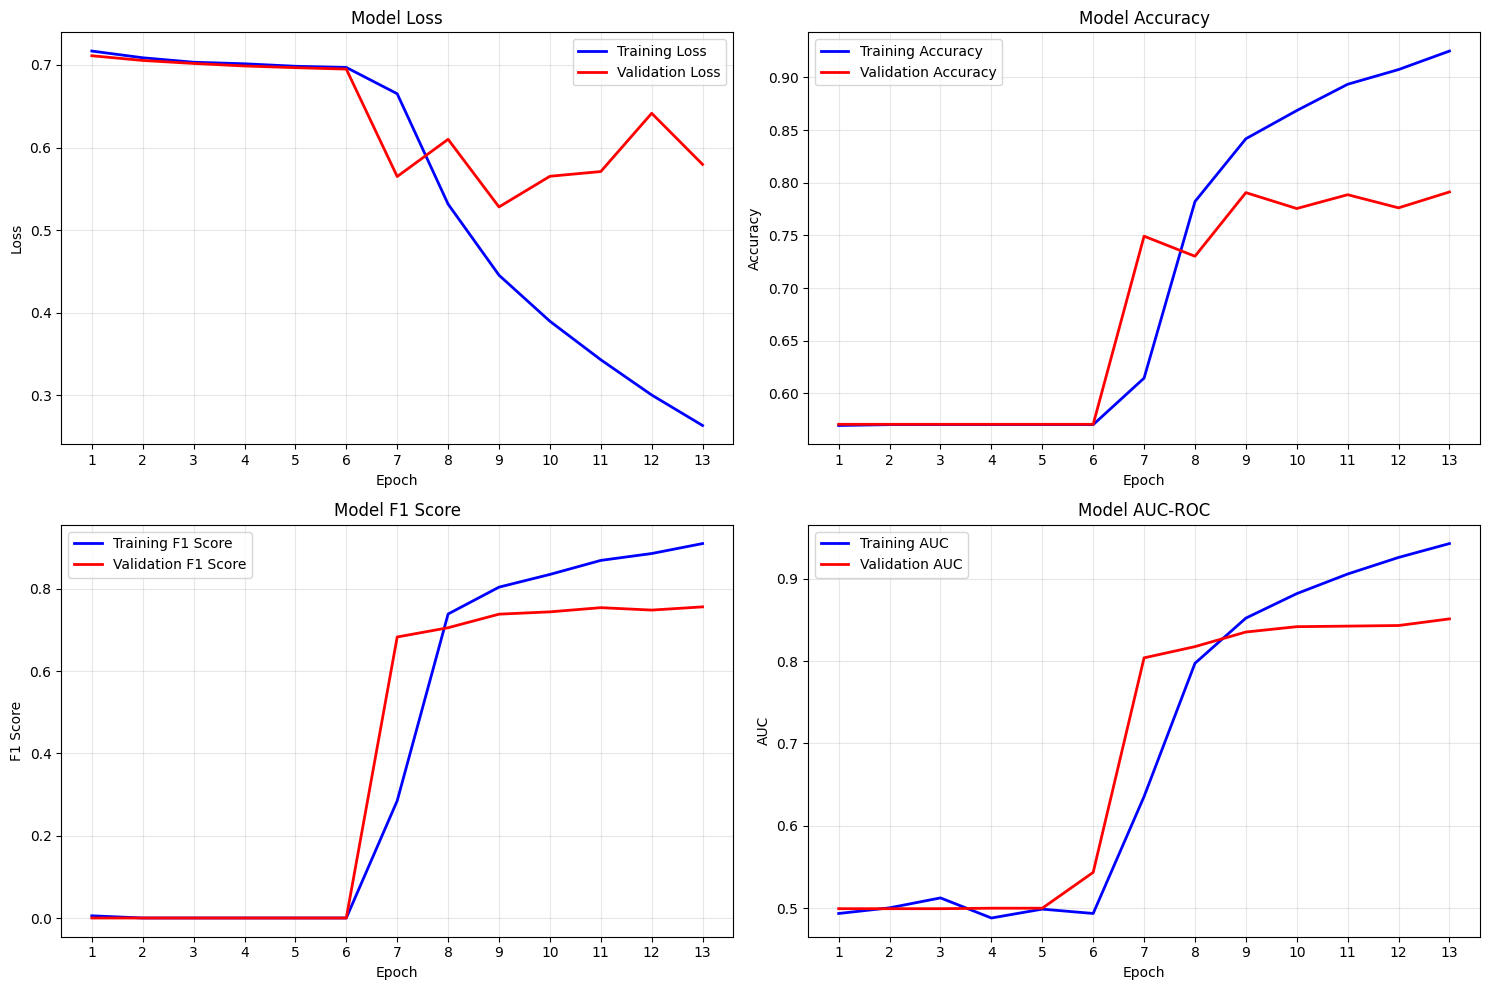

Learning Rate: 0.0001
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.5796
Accuracy: 0.7912
Training F1 Score: 0.9104
Validation F1 Score: 0.7565


In [32]:
LEARNING_RATE = 0.0001
EMB_DIM = 128
BATCH_SIZE = 32

lstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    LSTM(64, recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    LSTM(32, recurrent_dropout=0.2, dropout=0.2, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

hist_lstm = compile_fit(lstm)
plot_training_history(hist_lstm)

lstm_hists.append(hist_lstm)
lstm_models.append(lstm)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - AUC: 0.5127 - Precision: 0.4352 - Recall: 0.1246 - accuracy: 0.5544 - loss: 0.7177 - val_AUC: 0.4721 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7106
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 0.5047 - Precision: 0.4783 - Recall: 0.0084 - accuracy: 0.5700 - loss: 0.7094 - val_AUC: 0.4956 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7059
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4933 - Precision: 0.5556 - Recall: 0.0019 - accuracy: 0.5704 - loss: 0.7058 - val_AUC: 0.5983 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7027
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.6565 - Precision: 0.7844 - Recall: 0.2002 - accuracy: 0.6327 - loss: 0.6612 - val_AUC: 0.8188 - val_Precision: 0.9228 - val_Recall: 0.4572 - val_accuracy: 0.7505 - val_loss: 0.5509
Epo

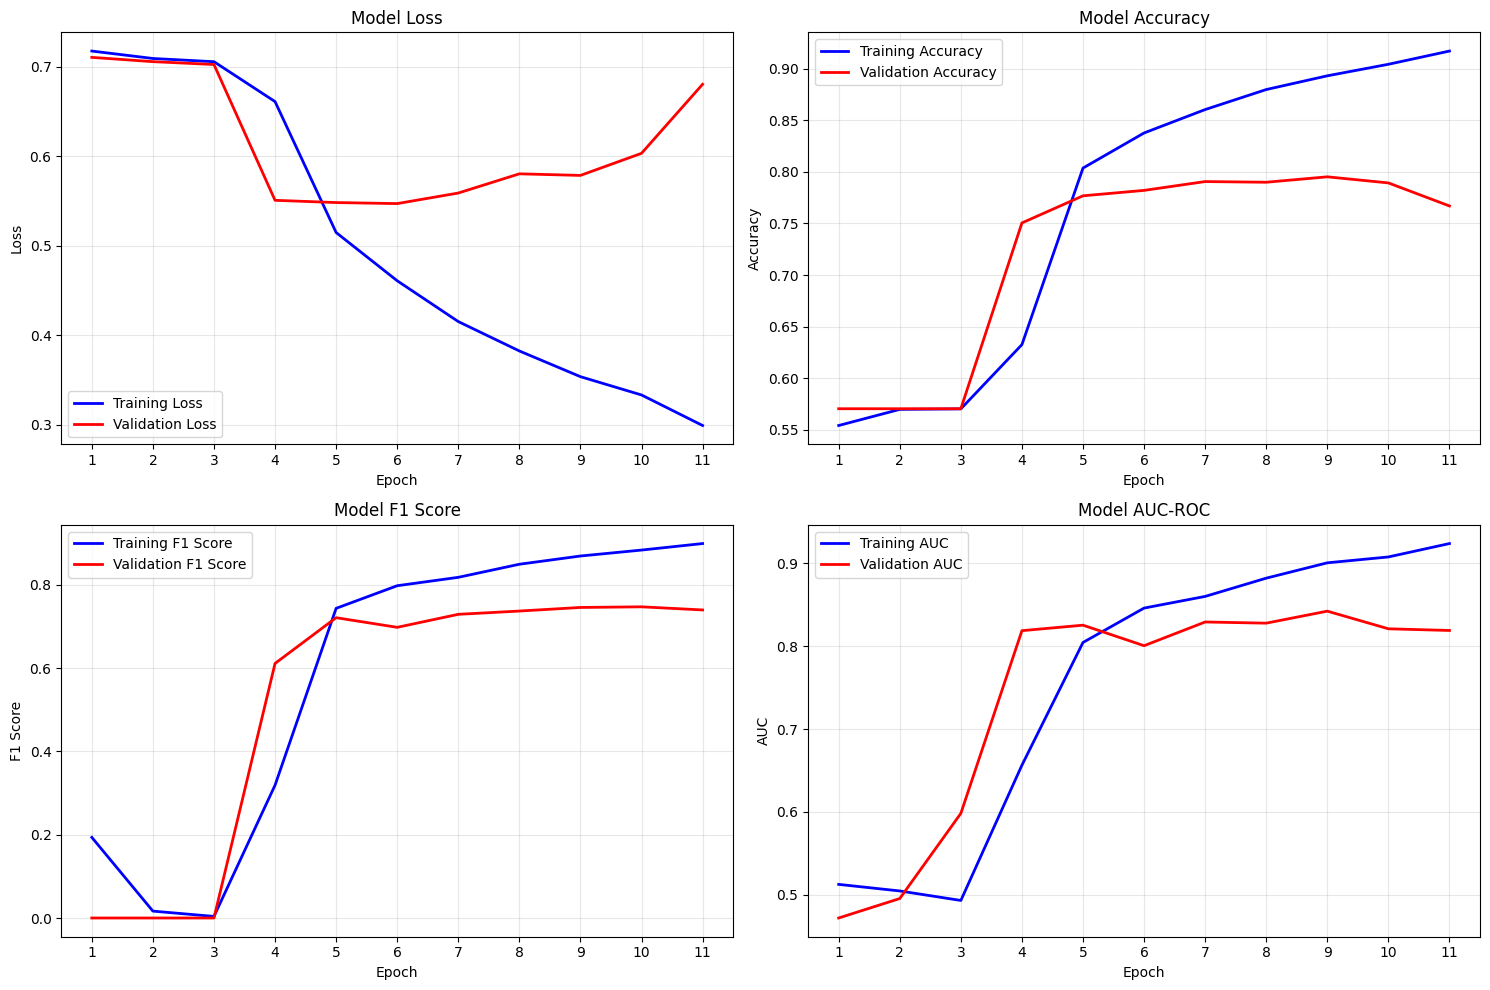

Learning Rate: 0.0001
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.6806
Accuracy: 0.7669
Training F1 Score: 0.8994
Validation F1 Score: 0.7399


In [33]:
LEARNING_RATE = 0.0001
EMB_DIM = 128
BATCH_SIZE = 32

lstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    LSTM(64, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    LSTM(32, recurrent_dropout=0.3, dropout=0.3, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

hist_lstm = compile_fit(lstm)
plot_training_history(hist_lstm)

lstm_hists.append(hist_lstm)
lstm_models.append(lstm)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 0.5088 - Precision: 0.4337 - Recall: 0.0550 - accuracy: 0.5631 - loss: 0.7171 - val_AUC: 0.4719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7114
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 0.5068 - Precision: 1.0000 - Recall: 0.0015 - accuracy: 0.5709 - loss: 0.7097 - val_AUC: 0.4994 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7069
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 0.4887 - Precision: 0.2857 - Recall: 7.6423e-04 - accuracy: 0.5698 - loss: 0.7077 - val_AUC: 0.4988 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7040
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 0.4989 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5701 - loss: 0.7036 - val_AUC: 0.4904 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - 

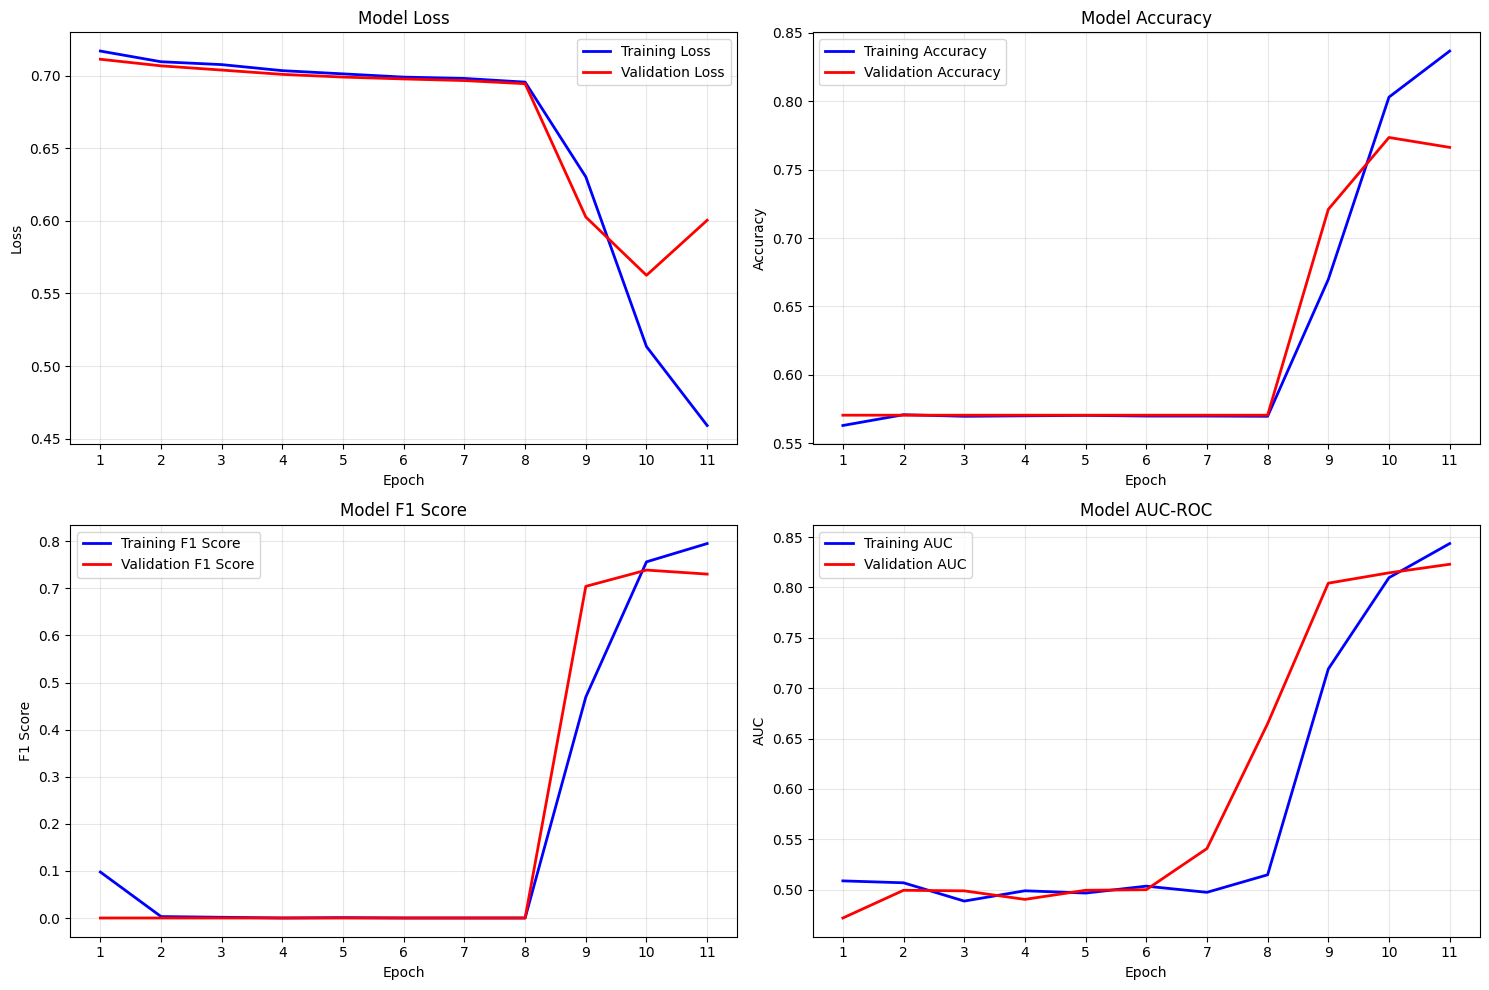

Learning Rate: 0.0001
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.6005
Accuracy: 0.7663
Training F1 Score: 0.7951
Validation F1 Score: 0.7303


In [34]:
LEARNING_RATE = 0.0001
EMB_DIM = 128
BATCH_SIZE = 32

lstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    LSTM(64, recurrent_dropout=0.4, return_sequences=True, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    LSTM(32, recurrent_dropout=0.4, dropout=0.4, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

hist_lstm = compile_fit(lstm)
plot_training_history(hist_lstm)

lstm_hists.append(hist_lstm)
lstm_models.append(lstm)

Increasing dropout only really delayed the overfitting, and didn't really improve the final performance of the model. I stuck with the moderate dropout rates and moved on to tuning the L2 regularization.

### L2 Regularization

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - AUC: 0.4987 - Precision: 0.4396 - Recall: 0.0348 - accuracy: 0.5662 - loss: 0.8364 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.8107
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 0.4984 - Precision: 0.5714 - Recall: 0.0015 - accuracy: 0.5704 - loss: 0.7948 - val_AUC: 0.4893 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7780
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.4869 - Precision: 0.6667 - Recall: 7.6423e-04 - accuracy: 0.5704 - loss: 0.7681 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7552
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - AUC: 0.4868 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7489 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - 

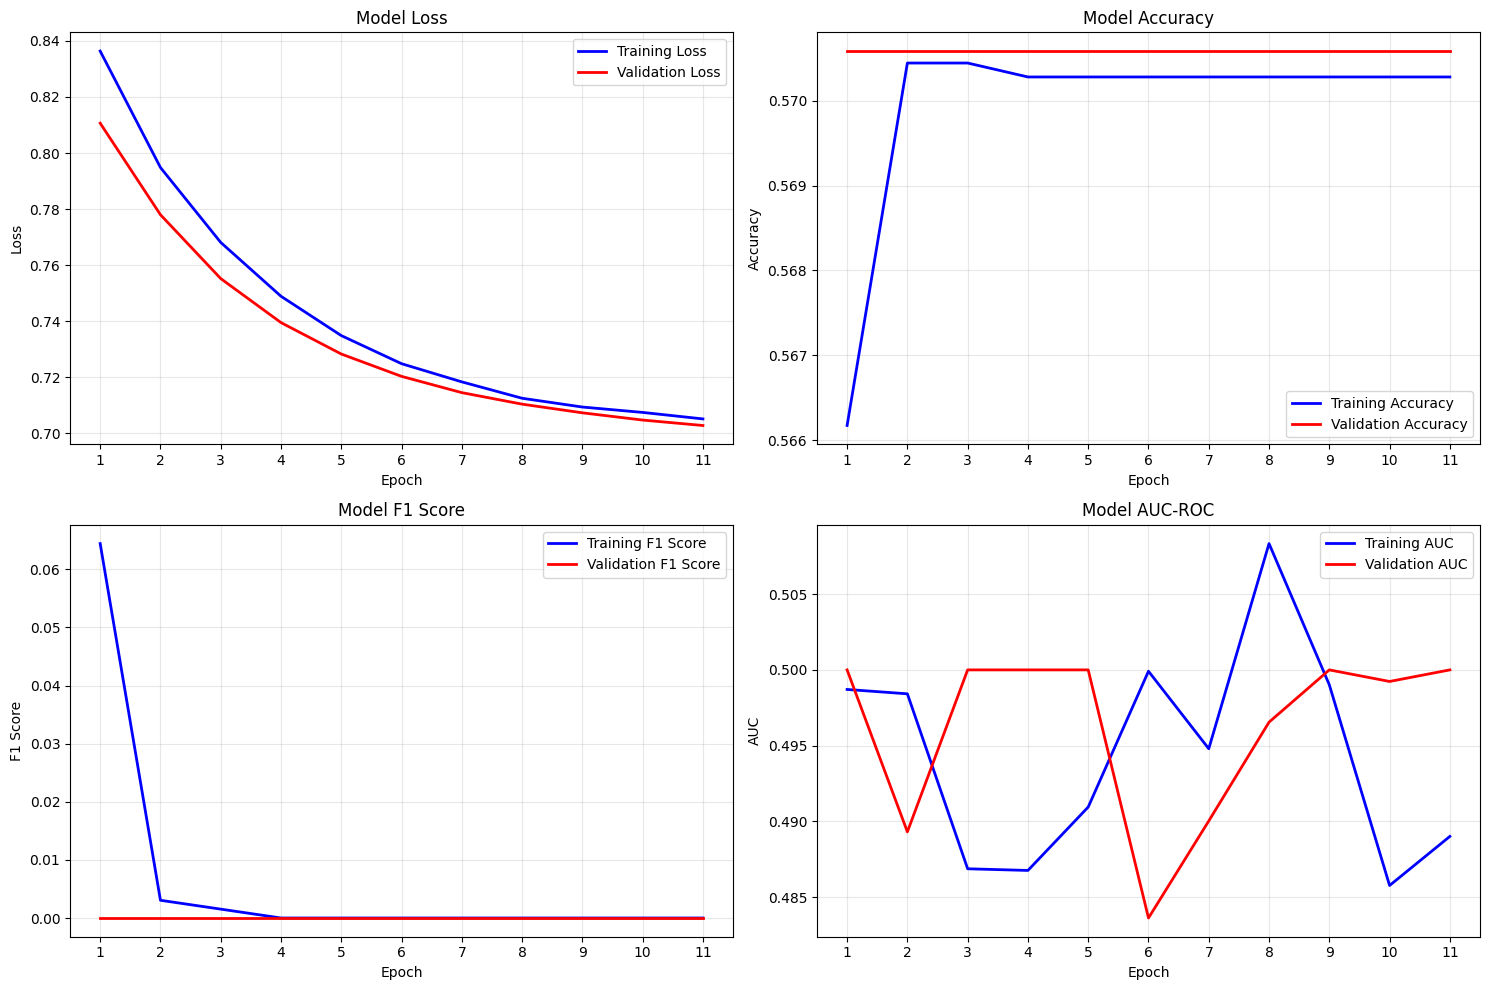

Learning Rate: 0.0001
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.7027
Accuracy: 0.5706
Training F1 Score: 0.0000
Validation F1 Score: 0.0000


In [35]:
LEARNING_RATE = 0.0001
EMB_DIM = 128
BATCH_SIZE = 32

lstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    LSTM(64, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.0005), 
         recurrent_regularizer=l2(0.0005)),
    LSTM(32, recurrent_dropout=0.3, dropout=0.3, kernel_regularizer=l2(0.0005), 
         recurrent_regularizer=l2(0.0005)),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

hist_lstm = compile_fit(lstm)
plot_training_history(hist_lstm)

lstm_hists.append(hist_lstm)
lstm_models.append(lstm)

This increase was way too strong, the model was now likely underfitting and converging too slowly.

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 0.5153 - Precision: 0.5267 - Recall: 0.0302 - accuracy: 0.5716 - loss: 0.7460 - val_AUC: 0.5138 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7369
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.4986 - Precision: 0.5714 - Recall: 0.0015 - accuracy: 0.5704 - loss: 0.7325 - val_AUC: 0.4994 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7261
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4998 - Precision: 0.3333 - Recall: 3.8212e-04 - accuracy: 0.5701 - loss: 0.7227 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7181
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 0.4964 - Precision: 0.5000 - Recall: 7.6423e-04 - accuracy: 0.5703 - loss: 0.7163 - val_AUC: 0.4994 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_

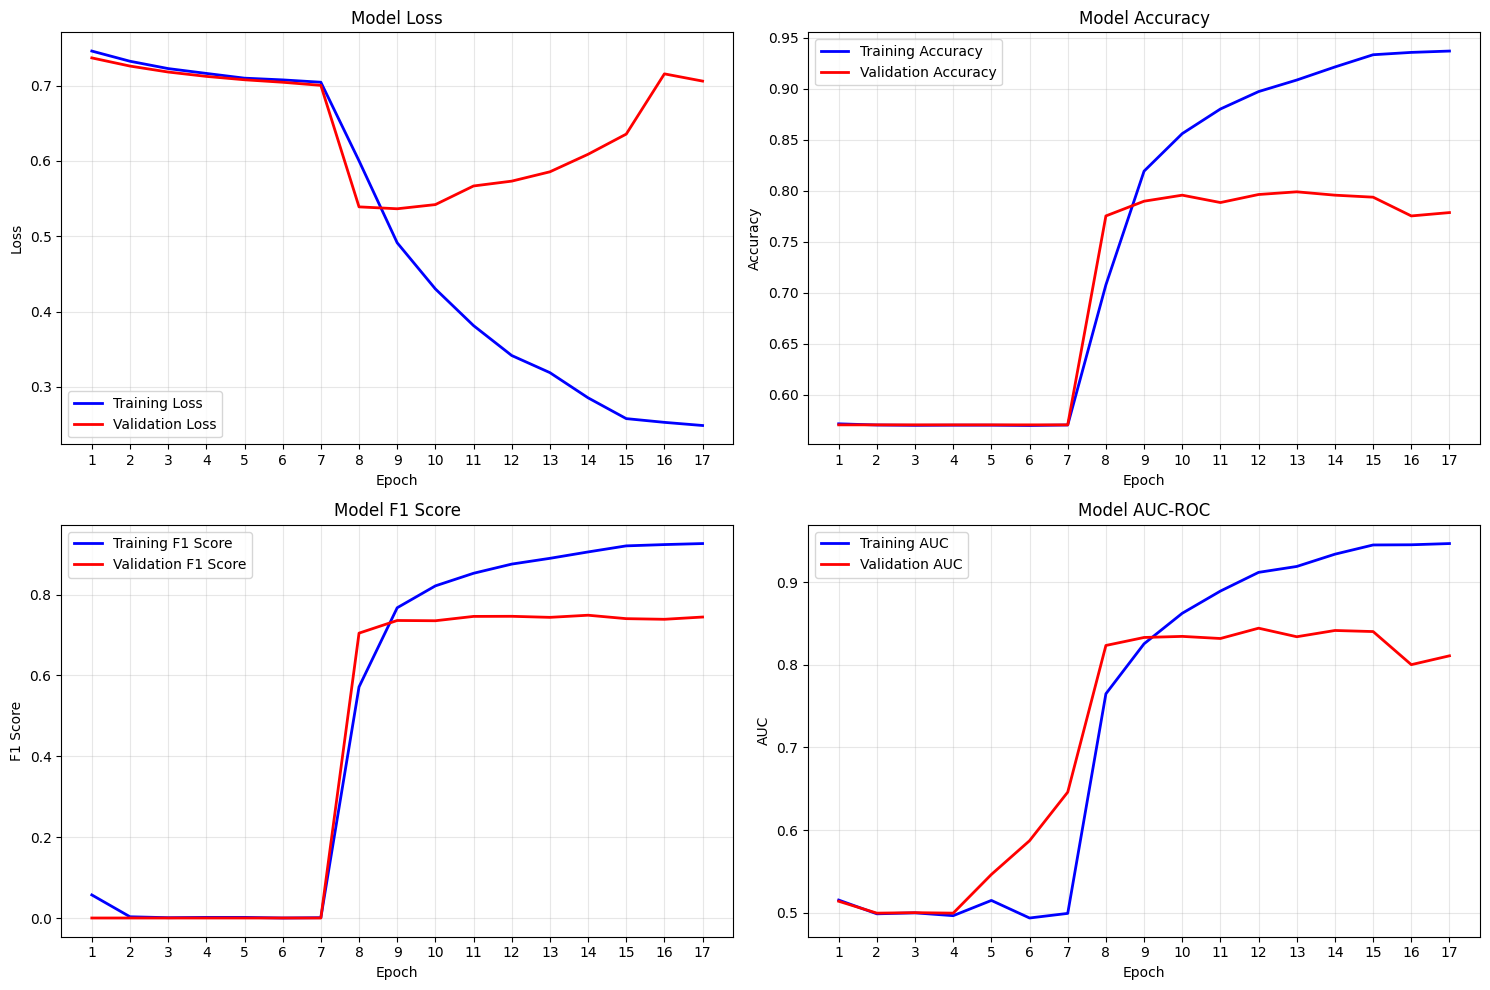

Learning Rate: 0.0001
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.7061
Accuracy: 0.7787
Training F1 Score: 0.9263
Validation F1 Score: 0.7445


In [37]:
LEARNING_RATE = 0.0001
EMB_DIM = 128
BATCH_SIZE = 32

lstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    LSTM(64, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.0002), 
         recurrent_regularizer=l2(0.0002)),
    LSTM(32, recurrent_dropout=0.3, dropout=0.3, kernel_regularizer=l2(0.0002), 
         recurrent_regularizer=l2(0.0002)),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

hist_lstm = compile_fit(lstm)
plot_training_history(hist_lstm)

lstm_hists.append(hist_lstm)
lstm_models.append(lstm)

This did not help with the overfitting problem very much, and did not end up making the final model's scores any better. I decided to adjust other parameters first to help alleviate this.

### Learning Rate

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - AUC: 0.5035 - Precision: 0.4107 - Recall: 0.0088 - accuracy: 0.5686 - loss: 0.7084 - val_AUC: 0.4971 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6998
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5061 - Precision: 1.0000 - Recall: 3.8212e-04 - accuracy: 0.5704 - loss: 0.6970 - val_AUC: 0.6821 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6918
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 0.7058 - Precision: 0.8343 - Recall: 0.3924 - accuracy: 0.7054 - loss: 0.6061 - val_AUC: 0.6731 - val_Precision: 0.9300 - val_Recall: 0.3654 - val_accuracy: 0.7157 - val_loss: 0.5820
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.7117 - Precision: 0.8882 - Recall: 0.4612 - accuracy: 0.7435 - loss: 0.5689 - val_AUC: 0.7097 - val_Precision: 0.8237 - val_Recall: 0.5000 - val_accuracy: 0.7393 - val_loss: 0.5794
Epoch 5

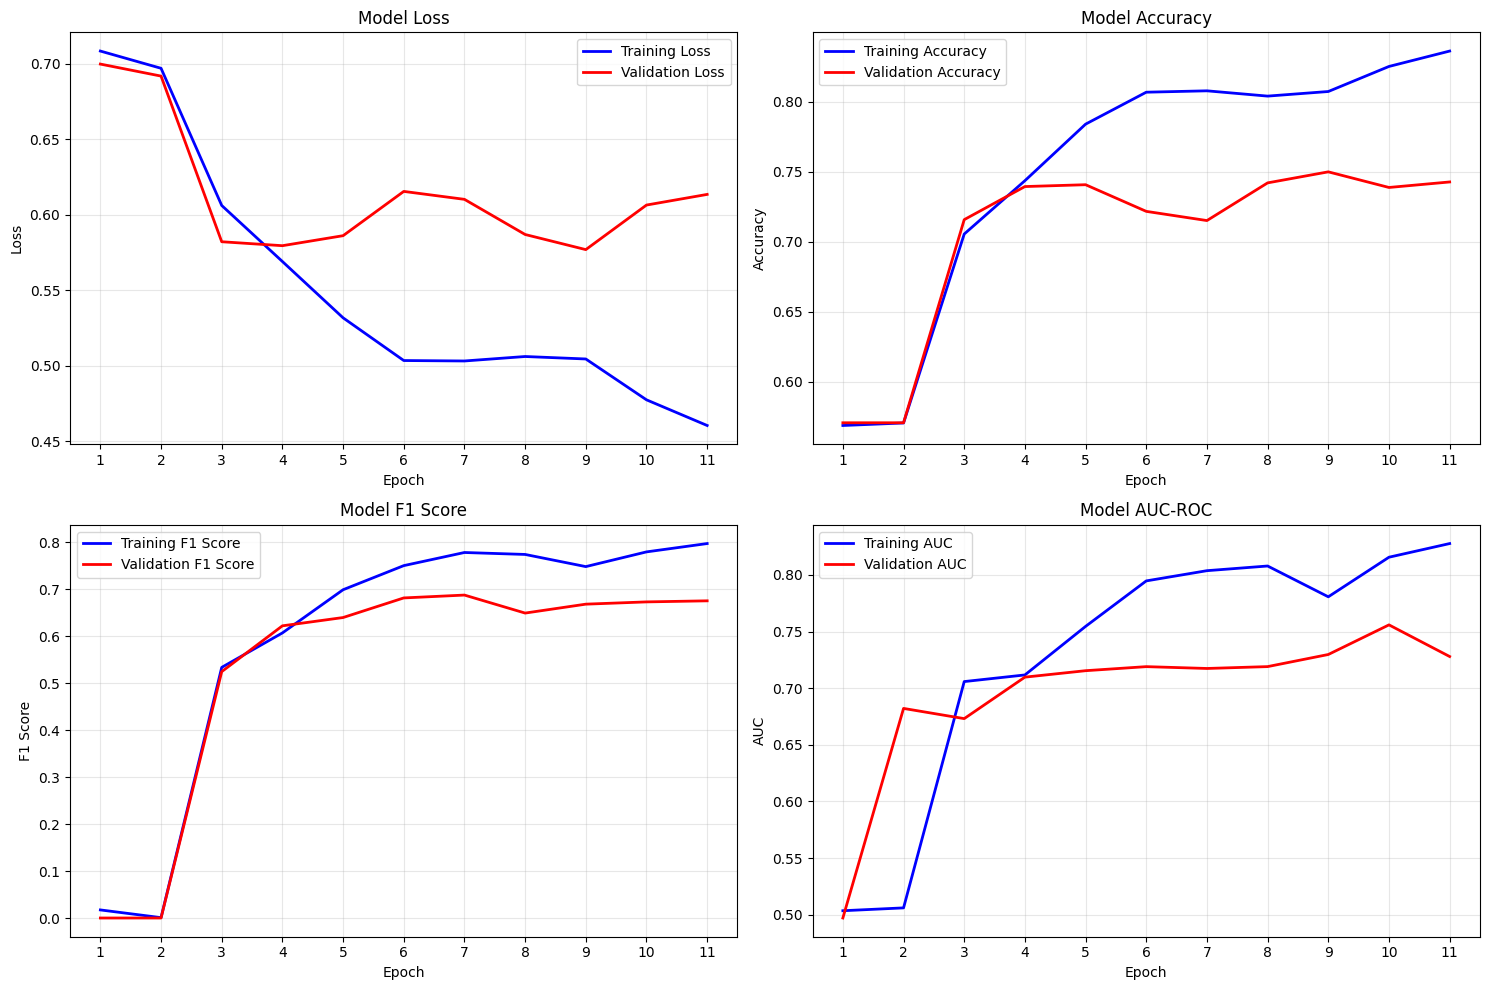

Learning Rate: 0.0005
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.6134
Accuracy: 0.7426
Training F1 Score: 0.7975
Validation F1 Score: 0.6755


In [38]:
LEARNING_RATE = 0.0005
EMB_DIM = 128
BATCH_SIZE = 32

lstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    LSTM(64, recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    LSTM(32, recurrent_dropout=0.2, dropout=0.2, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

hist_lstm = compile_fit(lstm)
plot_training_history(hist_lstm)

lstm_hists.append(hist_lstm)
lstm_models.append(lstm)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 0.4952 - Precision: 0.4038 - Recall: 0.0321 - accuracy: 0.5637 - loss: 0.7196 - val_AUC: 0.4898 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7142
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5218 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7115 - val_AUC: 0.5361 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7106
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4857 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7108 - val_AUC: 0.5209 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7078
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 0.4901 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7078 - val_AUC: 0.4960 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accurac

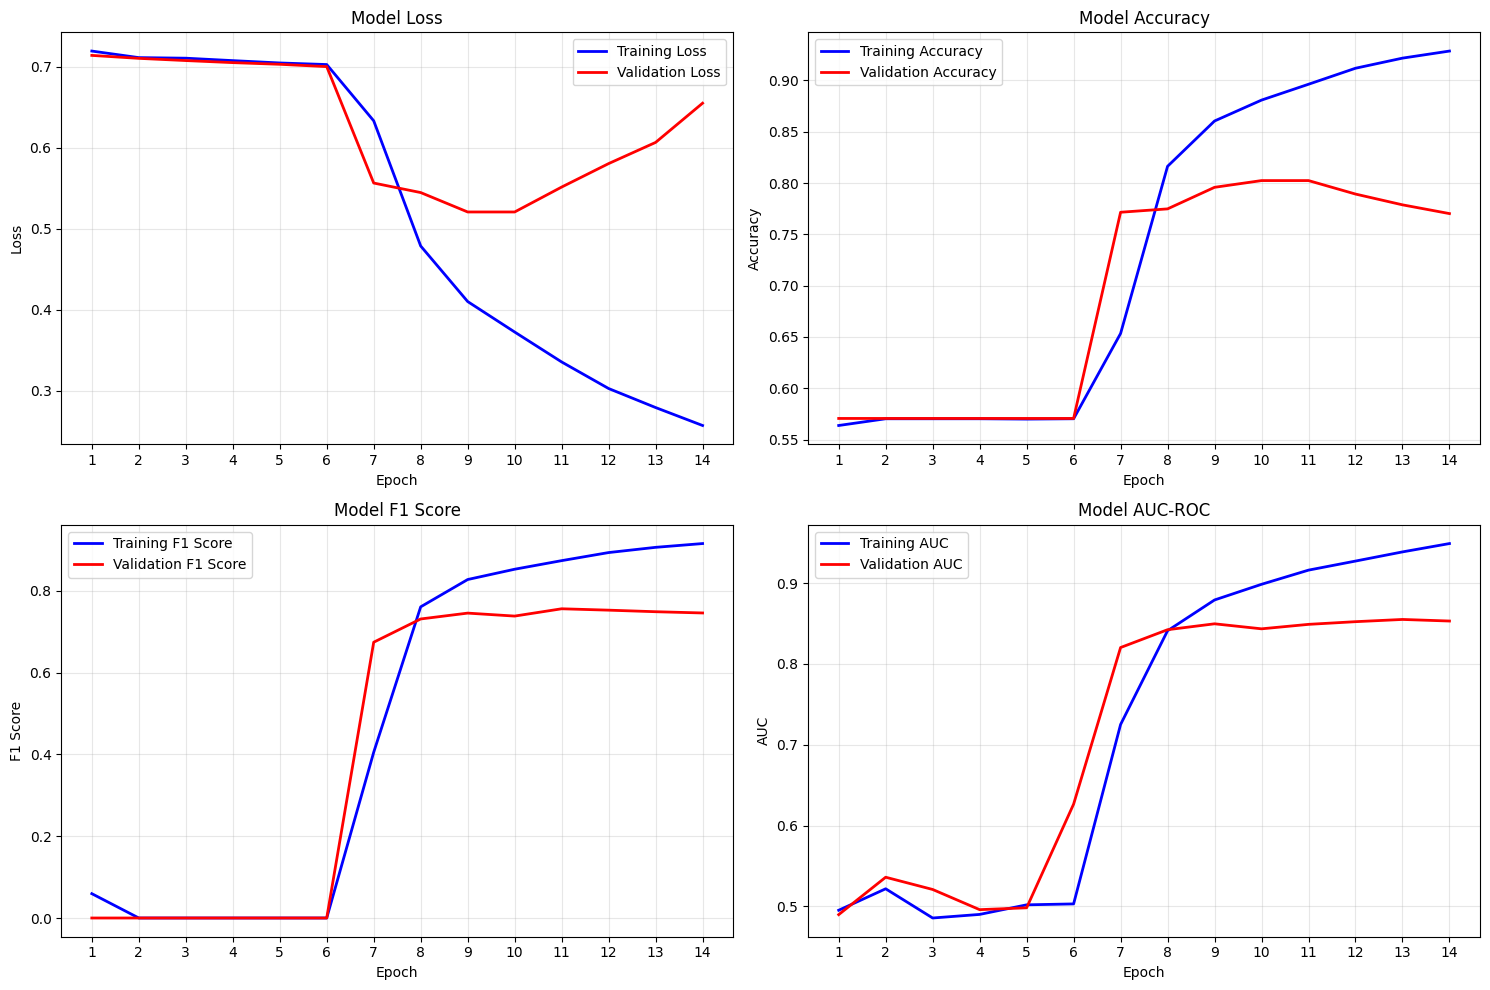

Learning Rate: 5e-05
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.6552
Accuracy: 0.7702
Training F1 Score: 0.9153
Validation F1 Score: 0.7456


In [39]:
LEARNING_RATE = 0.00005
EMB_DIM = 128
BATCH_SIZE = 32

lstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    LSTM(64, recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    LSTM(32, recurrent_dropout=0.2, dropout=0.2, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

hist_lstm = compile_fit(lstm)
plot_training_history(hist_lstm)

lstm_hists.append(hist_lstm)
lstm_models.append(lstm)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - AUC: 0.5002 - Precision: 0.4337 - Recall: 0.3114 - accuracy: 0.5294 - loss: 0.7269 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7238
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 0.4976 - Precision: 0.4211 - Recall: 0.0122 - accuracy: 0.5683 - loss: 0.7229 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7207
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.4949 - Precision: 0.8000 - Recall: 0.0015 - accuracy: 0.5708 - loss: 0.7200 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7181
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 0.5023 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5700 - loss: 0.7175 - val_AUC: 0.4994 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_

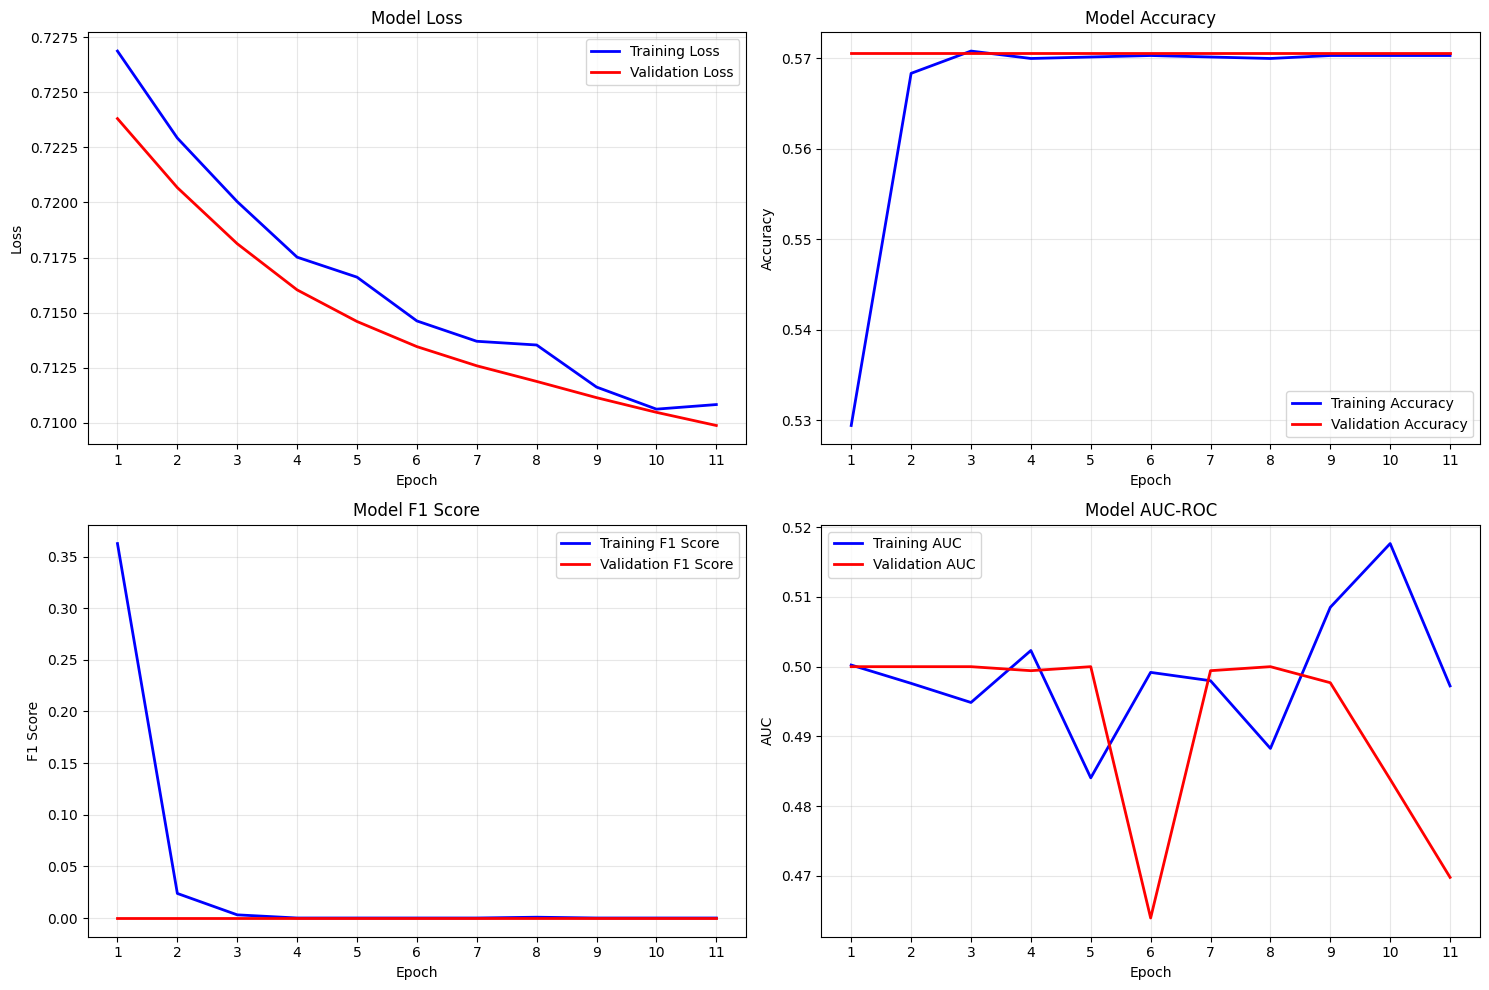

Learning Rate: 1e-05
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.7099
Accuracy: 0.5706
Training F1 Score: 0.0000
Validation F1 Score: 0.0000


In [40]:
LEARNING_RATE = 0.00001
EMB_DIM = 128
BATCH_SIZE = 32

lstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    LSTM(64, recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    LSTM(32, recurrent_dropout=0.2, dropout=0.2, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

hist_lstm = compile_fit(lstm)
plot_training_history(hist_lstm)

lstm_hists.append(hist_lstm)
lstm_models.append(lstm)

This learning rate was way too low. It was basically guessing the same class the entire time, which is why there is no f1 score.

I decided to stick with the learning rate of 0.00005, as that had slightly better results.

### Batch Size

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - AUC: 0.5103 - Precision: 0.4132 - Recall: 0.0936 - accuracy: 0.5534 - loss: 0.7227 - val_AUC: 0.4598 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7173
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.4940 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7161 - val_AUC: 0.4925 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7139
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5078 - Precision: 1.0000 - Recall: 3.8212e-04 - accuracy: 0.5704 - loss: 0.7129 - val_AUC: 0.5042 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7119
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5090 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7111 - val_AUC: 0.4772 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - v

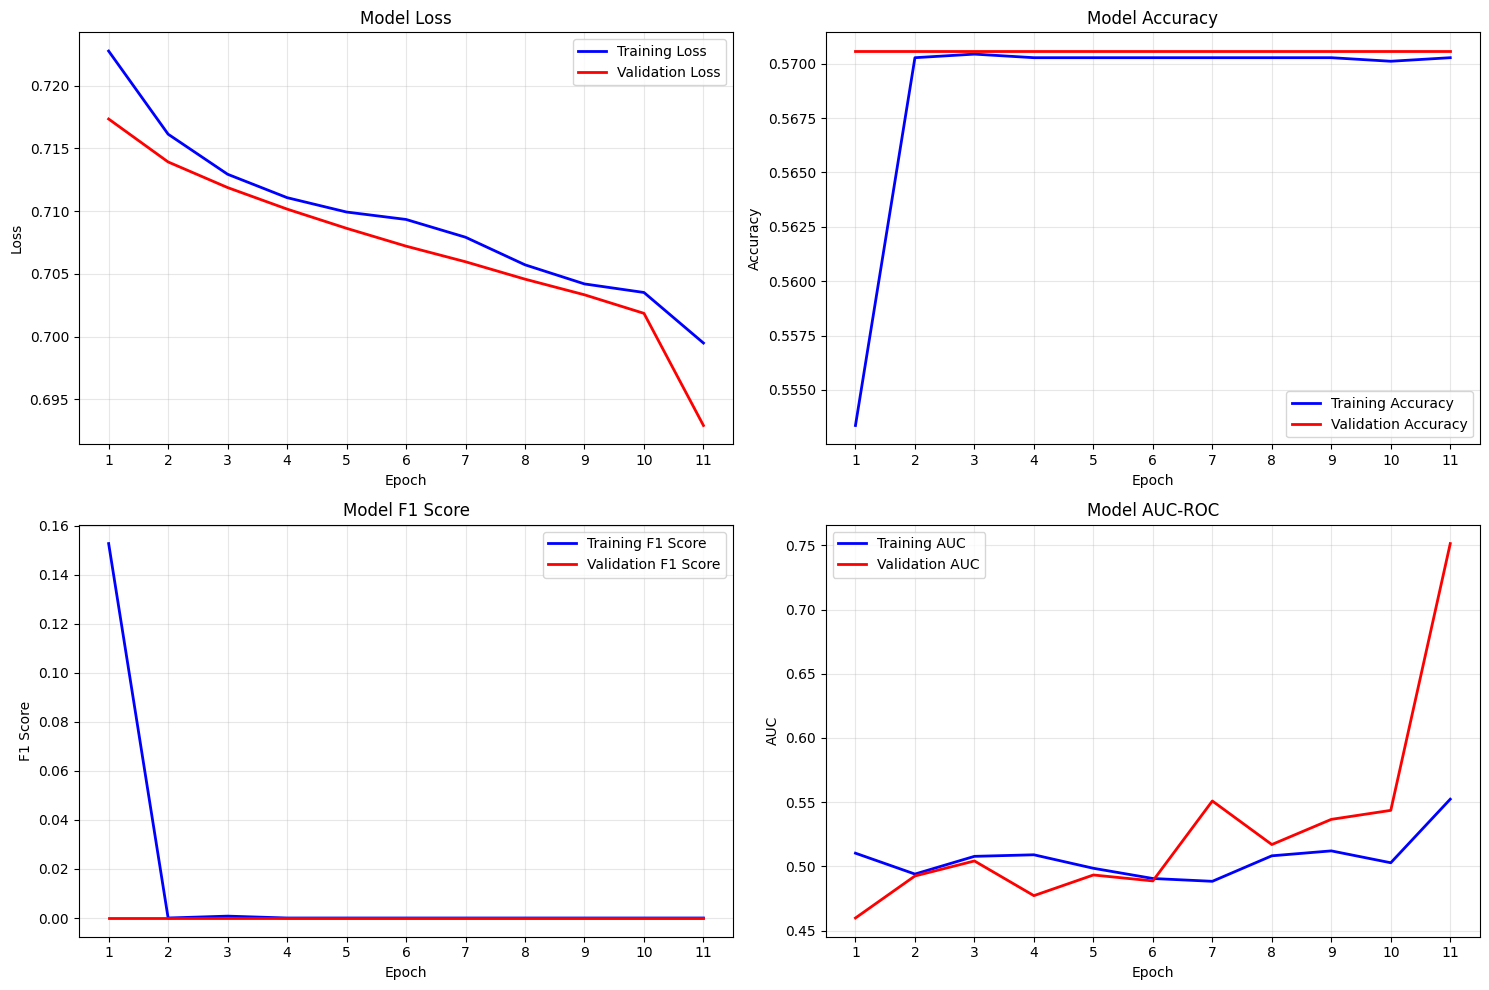

Learning Rate: 5e-05
Embedding Dimension: 128
Batch Size: 64

Results:
Loss: 0.6929
Accuracy: 0.5706
Training F1 Score: 0.0000
Validation F1 Score: 0.0000


In [41]:
LEARNING_RATE = 0.00005
EMB_DIM = 128
BATCH_SIZE = 64

lstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    LSTM(64, recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    LSTM(32, recurrent_dropout=0.2, dropout=0.2, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

hist_lstm = compile_fit(lstm)
plot_training_history(hist_lstm)

lstm_hists.append(hist_lstm)
lstm_models.append(lstm)

Epoch 1/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 0.5005 - Precision: 0.4527 - Recall: 0.0420 - accuracy: 0.5665 - loss: 0.7178 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7110
Epoch 2/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 0.5045 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5701 - loss: 0.7087 - val_AUC: 0.4879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7059
Epoch 3/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 0.4930 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7051 - val_AUC: 0.4965 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7023
Epoch 4/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 0.5036 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7014 - val_AUC: 0.4994 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accu

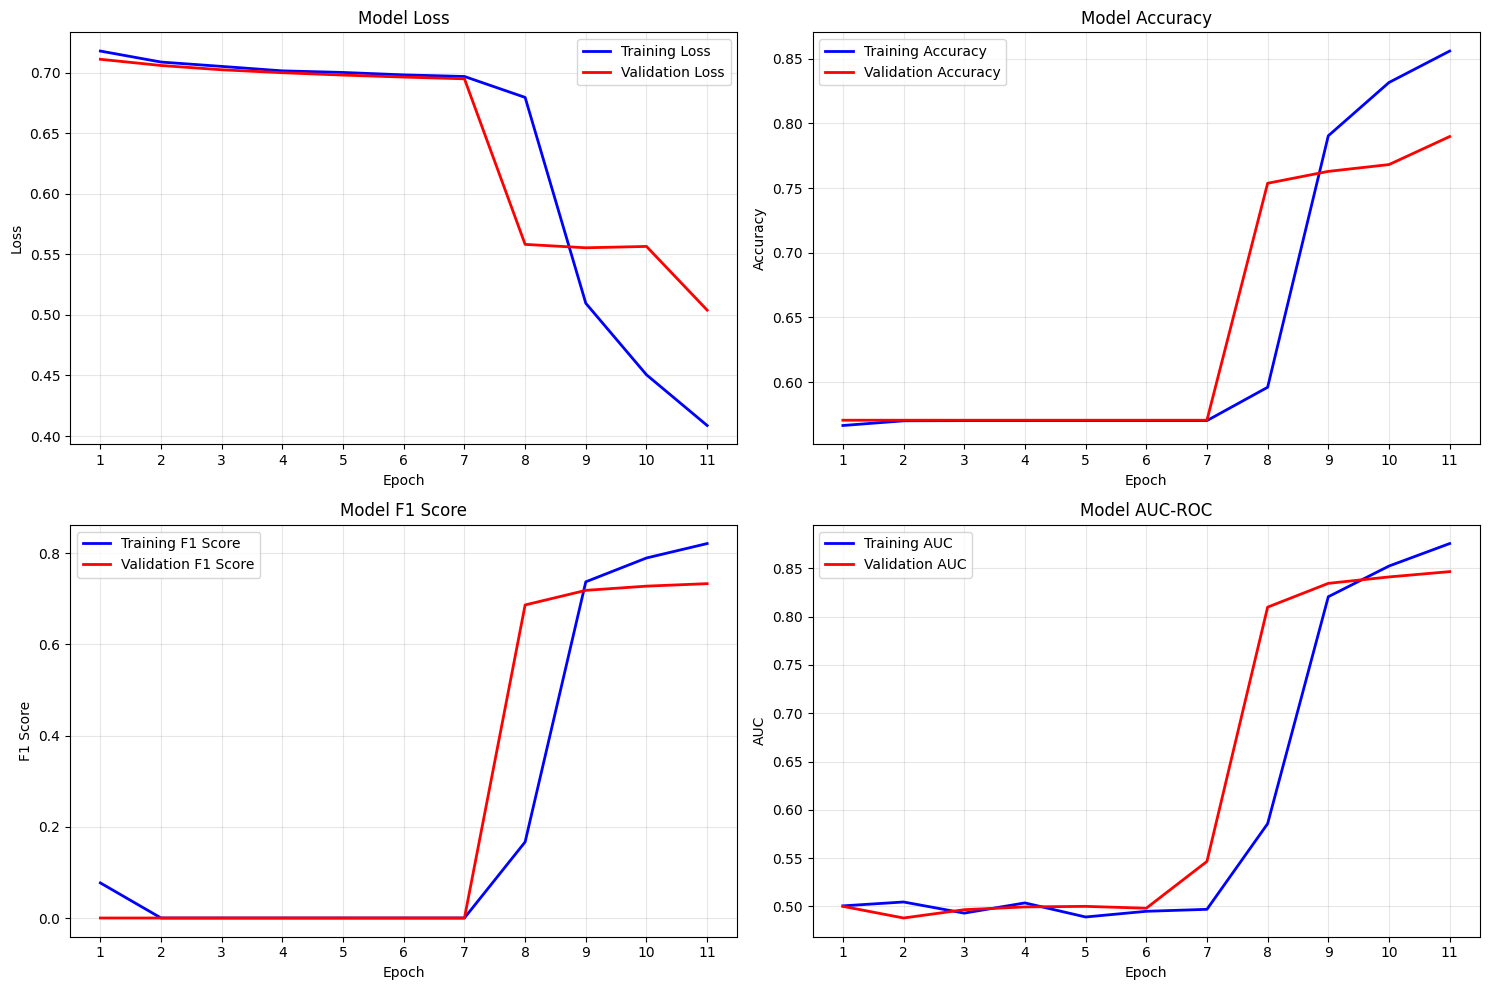

Learning Rate: 5e-05
Embedding Dimension: 128
Batch Size: 16

Results:
Loss: 0.5040
Accuracy: 0.7899
Training F1 Score: 0.8208
Validation F1 Score: 0.7329


In [42]:
LEARNING_RATE = 0.00005
EMB_DIM = 128
BATCH_SIZE = 16

lstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    LSTM(64, recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    LSTM(32, recurrent_dropout=0.2, dropout=0.2, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

hist_lstm = compile_fit(lstm)
plot_training_history(hist_lstm)

lstm_hists.append(hist_lstm)
lstm_models.append(lstm)

The medium batch size was best. This is likely because higher batch sizes use more data per update, leading to more precise/accurate adjustments, and too small batch sizes lead to more inconsistent adjustments in various directions.

### Embedding Dimensions

I had to eliminate the early stopping as it was stopping the training too early, I reduced the training epochs instead.

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - AUC: 0.5034 - Precision: 0.5000 - Recall: 0.0118 - accuracy: 0.5703 - loss: 0.7265 - val_AUC: 0.4994 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7212
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - AUC: 0.5026 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5701 - loss: 0.7193 - val_AUC: 0.4742 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7165
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - AUC: 0.5062 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7149 - val_AUC: 0.4977 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7128
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - AUC: 0.5197 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7109 - val_AUC: 0.5528 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accu

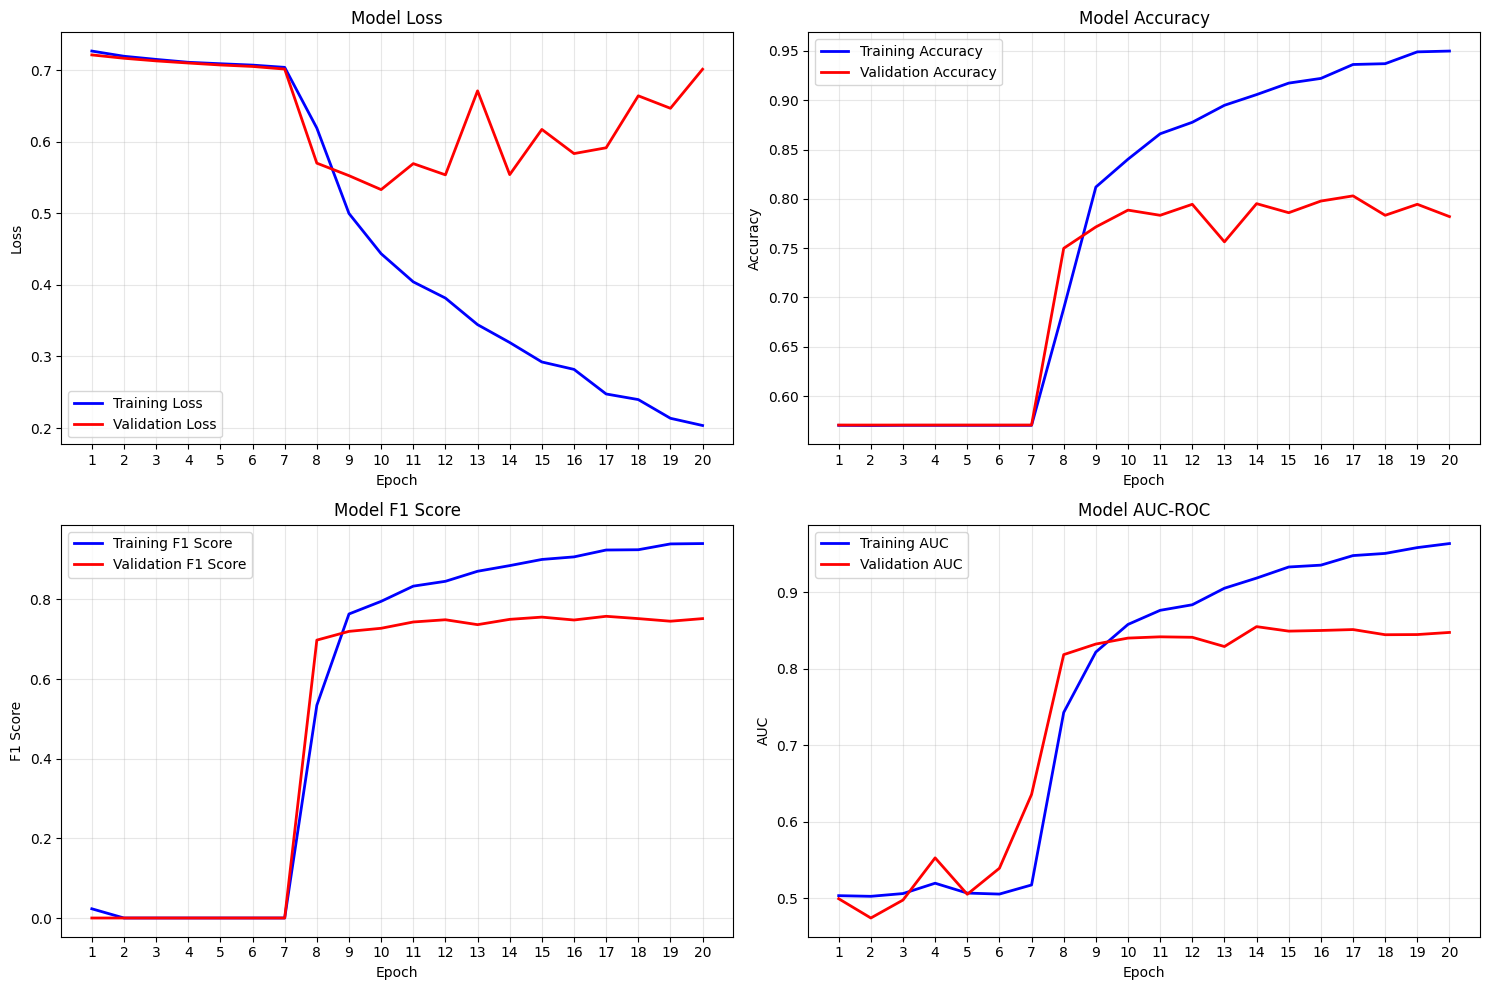

Learning Rate: 5e-05
Embedding Dimension: 256
Batch Size: 32

Results:
Loss: 0.7012
Accuracy: 0.7820
Training F1 Score: 0.9403
Validation F1 Score: 0.7519


In [47]:
LEARNING_RATE = 0.00005
EMB_DIM = 256
BATCH_SIZE = 32

lstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    LSTM(64, recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    LSTM(32, recurrent_dropout=0.2, dropout=0.2, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

hist_lstm = compile_fit(lstm, training_epochs=20, early_stopping=False)
plot_training_history(hist_lstm)

lstm_hists.append(hist_lstm)
lstm_models.append(lstm)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 0.4956 - Precision: 0.5000 - Recall: 0.0092 - accuracy: 0.5703 - loss: 0.7125 - val_AUC: 0.4841 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7086
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - AUC: 0.5025 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7074 - val_AUC: 0.4902 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7057
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - AUC: 0.5005 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7054 - val_AUC: 0.5494 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7037
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - AUC: 0.5044 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7031 - val_AUC: 0.4917 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy

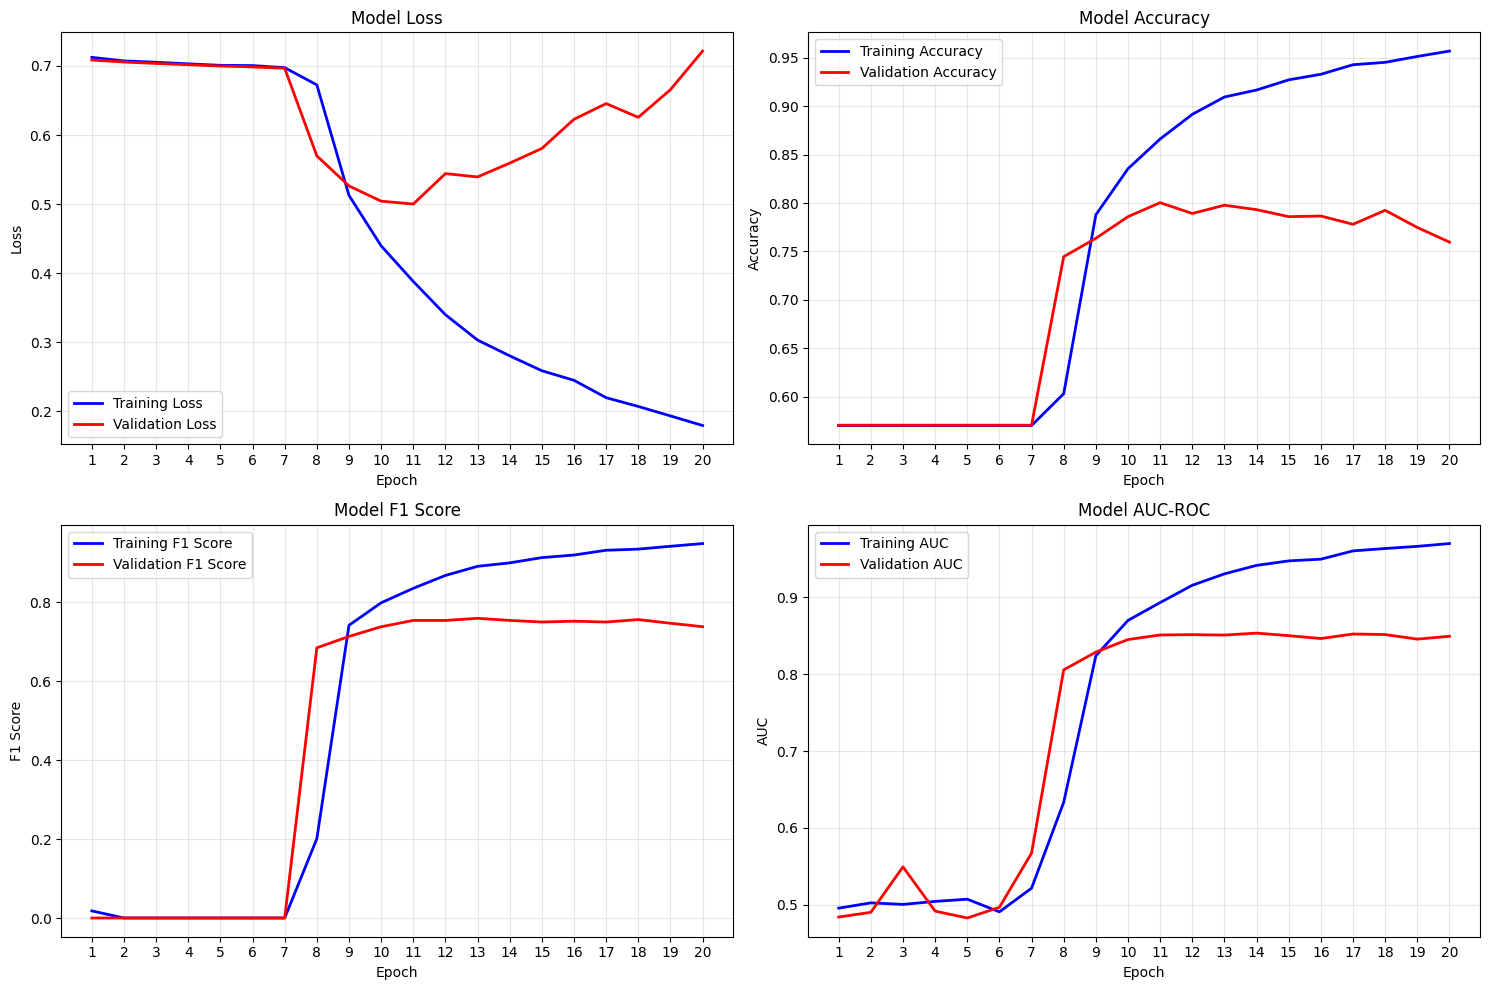

Learning Rate: 5e-05
Embedding Dimension: 64
Batch Size: 32

Results:
Loss: 0.7216
Accuracy: 0.7597
Training F1 Score: 0.9493
Validation F1 Score: 0.7386


In [48]:
LEARNING_RATE = 0.00005
EMB_DIM = 64
BATCH_SIZE = 32

lstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    LSTM(64, recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    LSTM(32, recurrent_dropout=0.2, dropout=0.2, kernel_regularizer=l2(0.0001), 
         recurrent_regularizer=l2(0.0001)),
    
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

hist_lstm = compile_fit(lstm, training_epochs=20, early_stopping=False)
plot_training_history(hist_lstm)

lstm_hists.append(hist_lstm)
lstm_models.append(lstm)

The model was not improving with any adjustments to these parameters. This indicated that these hyperparameters were likely not the issue, but rather my model architecture or data preprocessing.

I decided to move on to trying the Bidirectional LSTM and adjust the architecture from then on.

## Bidirectional LSTM

A biderectional LSTM has the long term memory capabilities of an LSTM, but in two directions. It uses the sequential input from both the beginning and the end, allowing it to see the input with better context. This is great for NLP because sentence structures often rely on what will be said later in the sentence to make sense of the beginning.

In [49]:
blstm_hists = []
blstm_models = []

Epoch 1/20


191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - AUC: 0.5249 - Precision: 0.4000 - Recall: 0.0015 - accuracy: 0.5700 - loss: 0.7271 - val_AUC: 0.6825 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7186
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - AUC: 0.6458 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7092 - val_AUC: 0.7229 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6977
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - AUC: 0.7680 - Precision: 0.9426 - Recall: 0.0879 - accuracy: 0.6057 - loss: 0.6705 - val_AUC: 0.7929 - val_Precision: 0.8961 - val_Recall: 0.3823 - val_accuracy: 0.7157 - val_loss: 0.6509
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - AUC: 0.8320 - Precision: 0.9061 - Recall: 0.4681 - accuracy: 0.7506 - loss: 0.6028 - val_AUC: 0.8242 - val_Precision: 0.8128 - val_Recall: 0.6040 - val_accuracy: 0.7702 - val_loss: 0.5829
Epoch 5/20
191

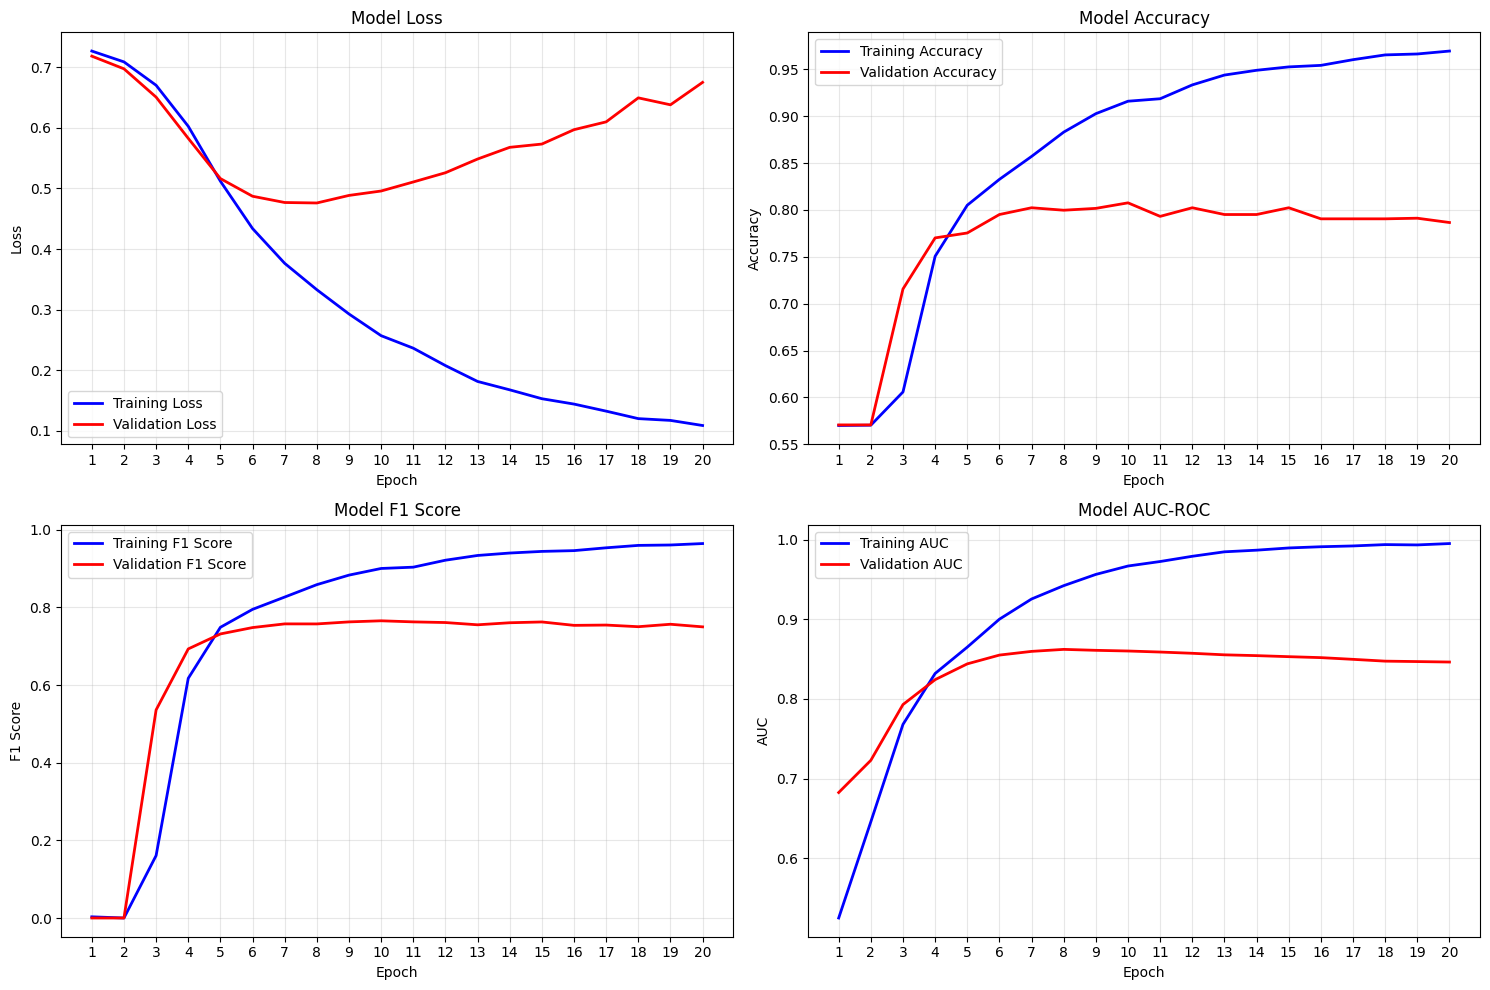

Learning Rate: 5e-05
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.6753
Accuracy: 0.7866
Training F1 Score: 0.9643
Validation F1 Score: 0.7498


In [50]:
LEARNING_RATE = 0.00005
EMB_DIM = 128
BATCH_SIZE = 32

blstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.0001), 
                       recurrent_regularizer=l2(0.0001))),

    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

hist_blstm = compile_fit(blstm, training_epochs=20, early_stopping=False)
plot_training_history(hist_blstm)

blstm_hists.append(hist_blstm)
blstm_models.append(blstm)

The scores were similar to before, but the updates were much more stable, showing promise. This meant that the model was learning (convergin) quicker and more accurately.

I started adjusting the architecture to more simple and complex versions. Simpler architectures would be more general and prevent overfitting, but may not learn the over-arching patterns of the tweets. Complex architectures would have the opposite effect.

I also tuned some of the other hyperparameters with the new architectures.

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - AUC: 0.5024 - Precision: 0.4404 - Recall: 0.0692 - accuracy: 0.5622 - loss: 0.8042 - val_AUC: 0.6120 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7863
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - AUC: 0.5024 - Precision: 0.4404 - Recall: 0.0692 - accuracy: 0.5622 - loss: 0.8042 - val_AUC: 0.6120 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7863
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - AUC: 0.6500 - Precision: 0.7786 - Recall: 0.0390 - accuracy: 0.5823 - loss: 0.7639 - val_AUC: 0.7559 - val_Precision: 0.9153 - val_Recall: 0.2477 - val_accuracy: 0.6671 - val_loss: 0.7173
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - AUC: 0.6500 - Precision: 0.7786 - Recall: 0.0390 - accuracy: 0.5823 - loss: 0.7639 - val_AUC: 0.7559 - val_Precision: 0.9153 - val_Recall: 0.2477 - val_accuracy: 0.6671 - val_loss: 0.7173
Epoch 3/

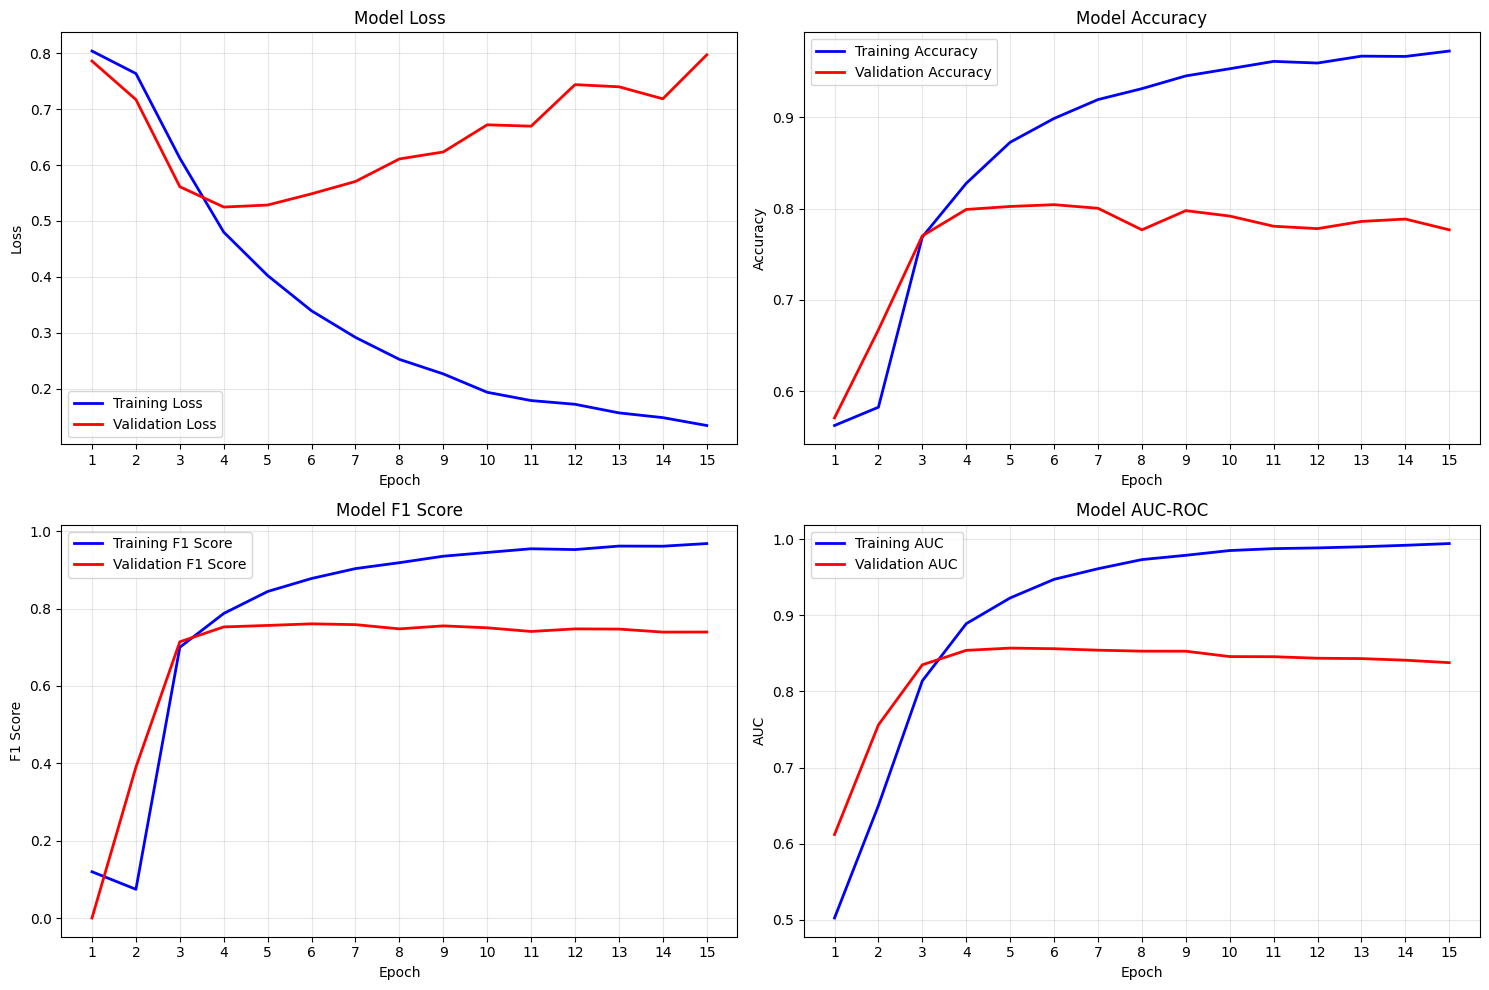

Learning Rate: 5e-05
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.7974
Accuracy: 0.7768
Training F1 Score: 0.9680
Validation F1 Score: 0.7393


In [55]:
LEARNING_RATE = 0.00005
EMB_DIM = 128
BATCH_SIZE = 32

blstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,
                       kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001))),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.0001), 
                       recurrent_regularizer=l2(0.0001))),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

hist_blstm = compile_fit(blstm, training_epochs=15, early_stopping=False)
plot_training_history(hist_blstm)

blstm_hists.append(hist_blstm)
blstm_models.append(blstm)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - AUC: 0.5202 - Precision: 0.4259 - Recall: 0.0428 - accuracy: 0.5639 - loss: 0.7162 - val_AUC: 0.6681 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7089
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - AUC: 0.5202 - Precision: 0.4259 - Recall: 0.0428 - accuracy: 0.5639 - loss: 0.7162 - val_AUC: 0.6681 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7089
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - AUC: 0.6259 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7037 - val_AUC: 0.7149 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6992
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - AUC: 0.6259 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.7037 - val_AUC: 0.7149 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.57

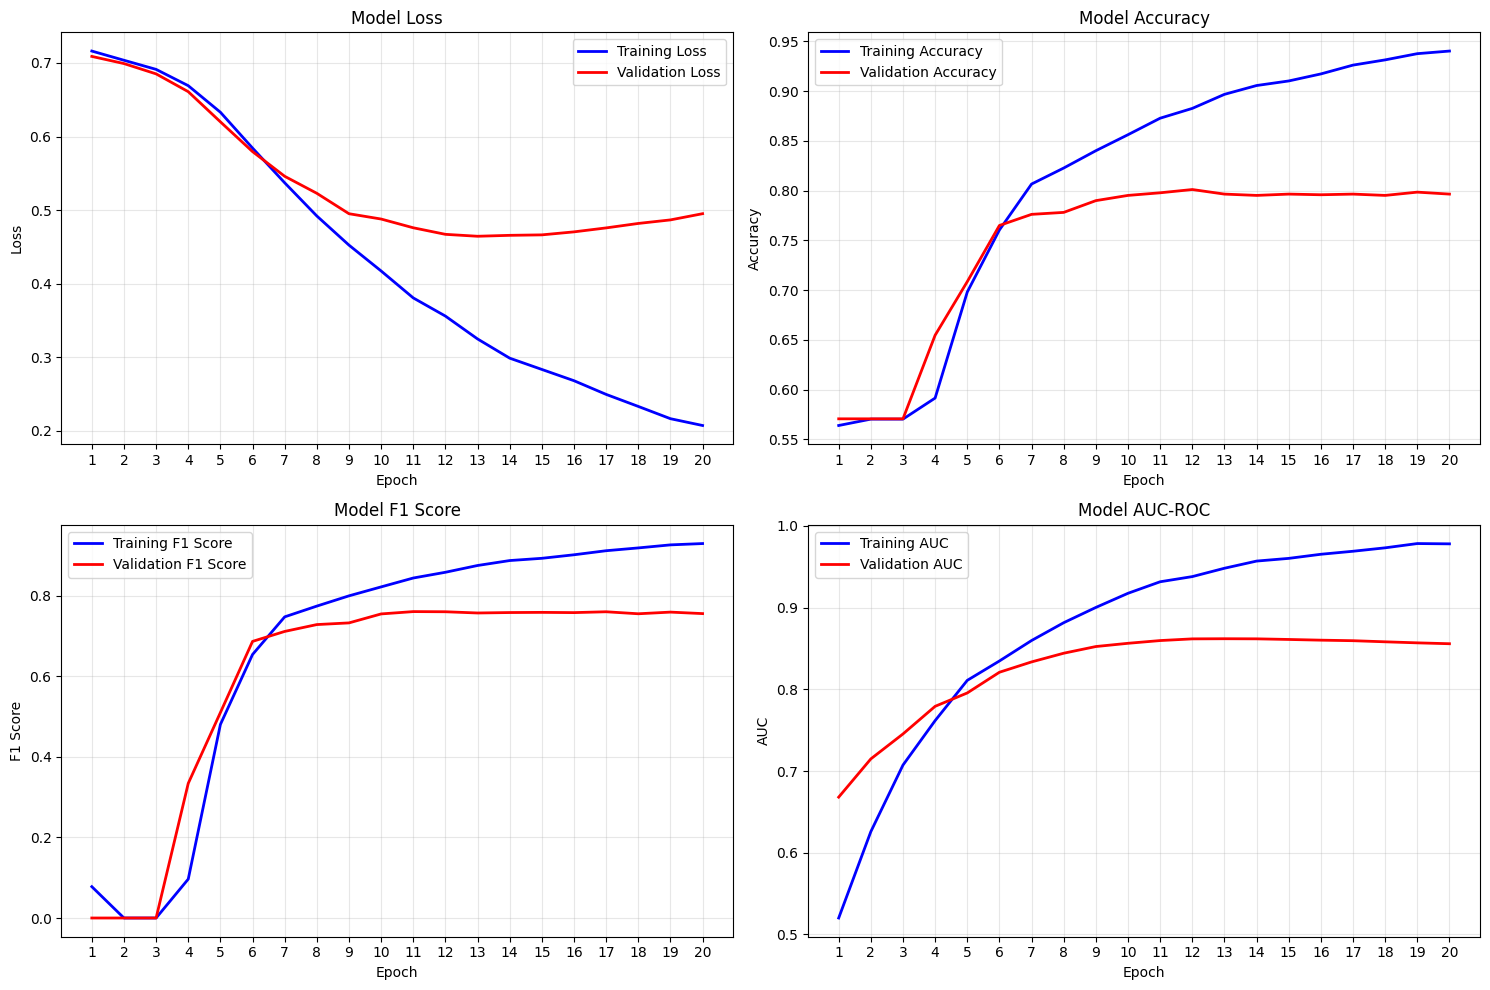

Learning Rate: 5e-05
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.4952
Accuracy: 0.7965
Training F1 Score: 0.9294
Validation F1 Score: 0.7555


In [57]:
LEARNING_RATE = 0.00005
EMB_DIM = 128
BATCH_SIZE = 32

blstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.0001), 
                       recurrent_regularizer=l2(0.0001))),

    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

hist_blstm = compile_fit(blstm, training_epochs=20, early_stopping=False)
plot_training_history(hist_blstm)

blstm_hists.append(hist_blstm)
blstm_models.append(blstm)

#### Further Testing

*This section is long and includes many combinations of parameters, I recommend minimizing this section.*

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - AUC: 0.5481 - Precision: 0.4814 - Recall: 0.1884 - accuracy: 0.5640 - loss: 0.7042 - val_AUC: 0.7173 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6964
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - AUC: 0.5481 - Precision: 0.4814 - Recall: 0.1884 - accuracy: 0.5640 - loss: 0.7042 - val_AUC: 0.7173 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6964
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - AUC: 0.6647 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.6921 - val_AUC: 0.7589 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6868
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - AUC: 0.6647 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.6921 - val_AUC: 0.7589 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.57

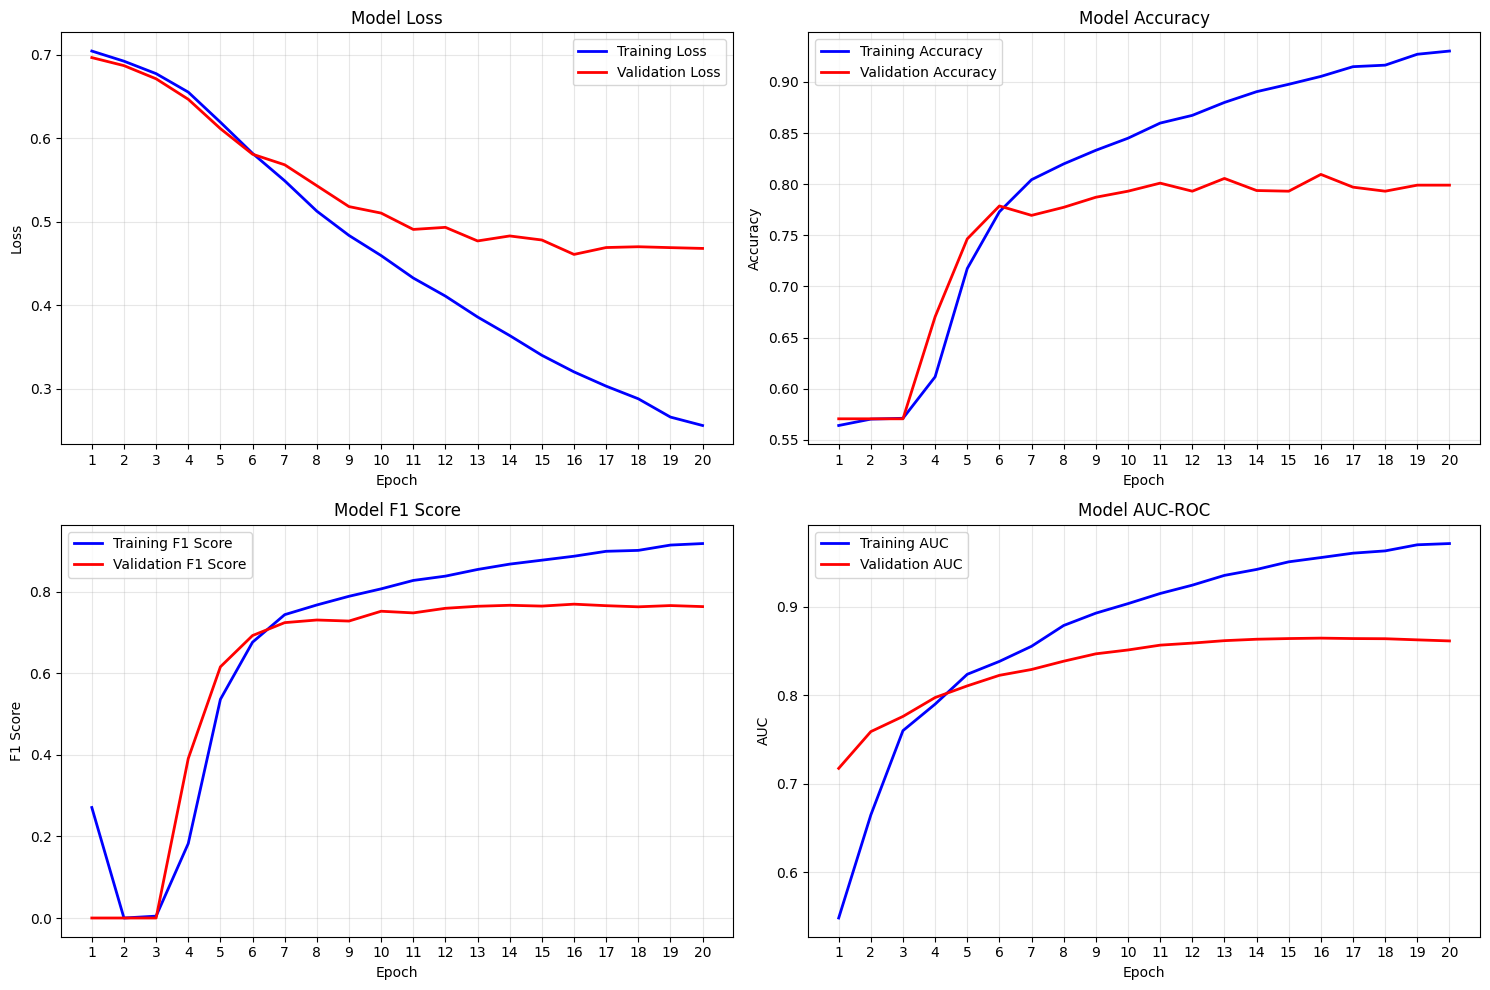

Learning Rate: 5e-05
Embedding Dimension: 128
Batch Size: 32

Results:
Loss: 0.4679
Accuracy: 0.7991
Training F1 Score: 0.9177
Validation F1 Score: 0.7632


In [58]:
LEARNING_RATE = 0.00005
EMB_DIM = 128
BATCH_SIZE = 32

blstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.0001), 
                       recurrent_regularizer=l2(0.0001))),

    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

hist_blstm = compile_fit(blstm, training_epochs=20, early_stopping=False)
plot_training_history(hist_blstm)

blstm_hists.append(hist_blstm)
blstm_models.append(blstm)

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 0.5184 - Precision: 0.4243 - Recall: 0.1670 - accuracy: 0.5447 - loss: 0.7041 - val_AUC: 0.6602 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6978
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 0.5184 - Precision: 0.4243 - Recall: 0.1670 - accuracy: 0.5447 - loss: 0.7041 - val_AUC: 0.6602 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6978
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5972 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.6942 - val_AUC: 0.7384 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6914
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5972 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.6942 - val_AUC: 0.7384 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.57

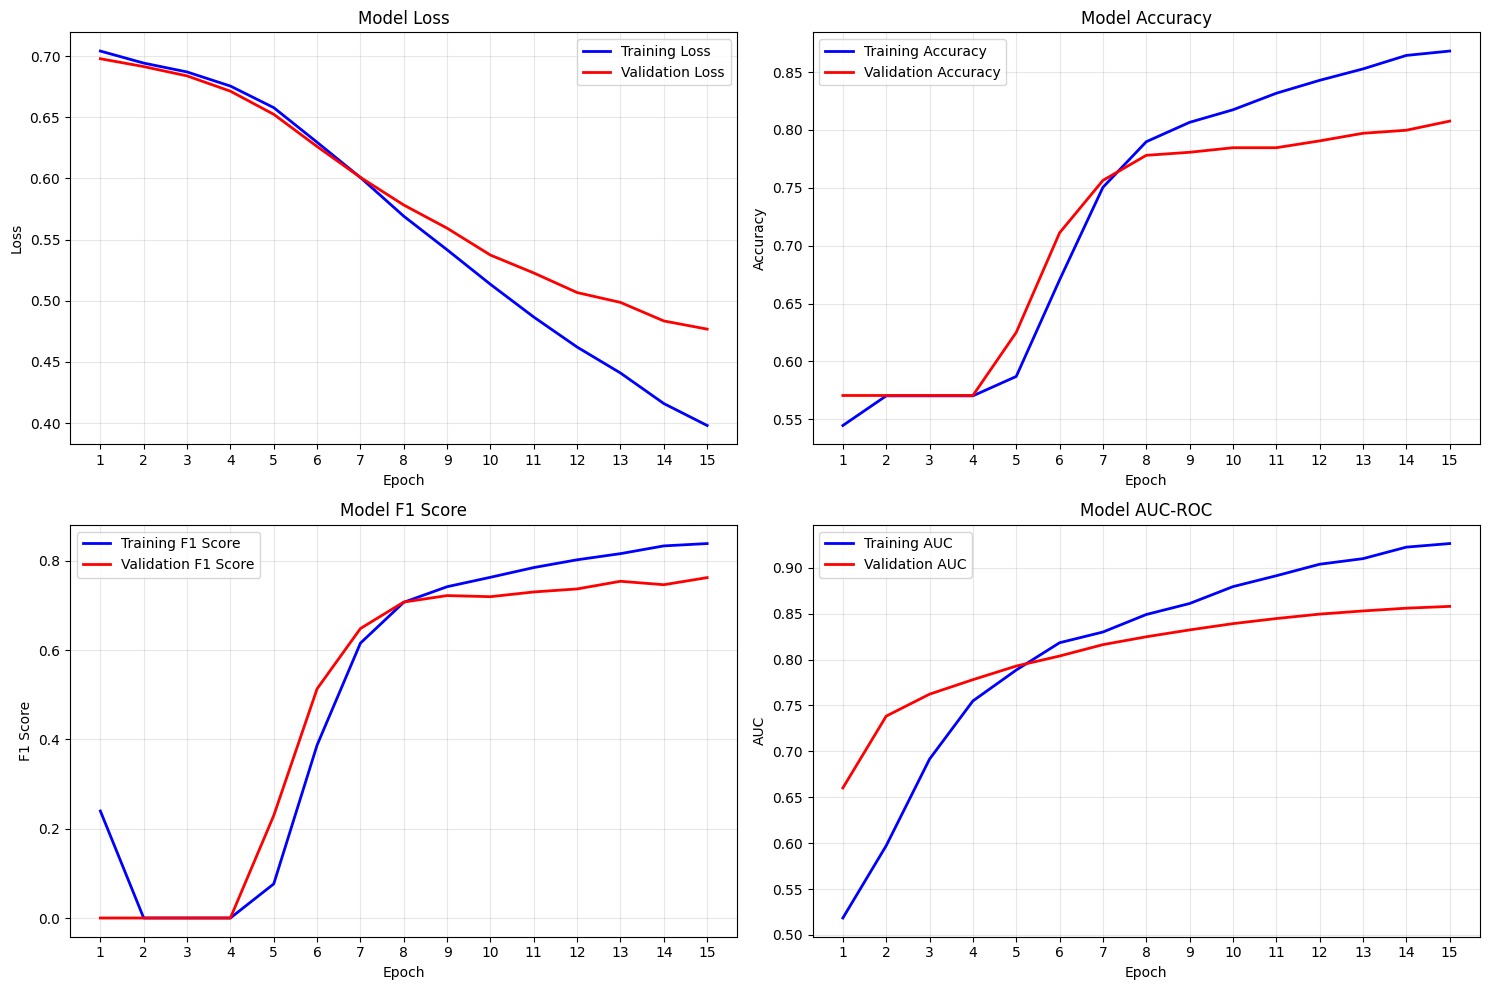

Learning Rate: 5e-05
Embedding Dimension: 64
Batch Size: 32

Results:
Loss: 0.4768
Accuracy: 0.8076
Training F1 Score: 0.8387
Validation F1 Score: 0.7624


In [59]:
LEARNING_RATE = 0.00005
EMB_DIM = 64
BATCH_SIZE = 32

blstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.0001), 
                       recurrent_regularizer=l2(0.0001))),

    Dense(1, activation='sigmoid')
])

hist_blstm = compile_fit(blstm, training_epochs=15, early_stopping=False)
plot_training_history(hist_blstm)

blstm_hists.append(hist_blstm)
blstm_models.append(blstm)

Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - AUC: 0.5154 - Precision: 0.4271 - Recall: 0.1131 - accuracy: 0.5537 - loss: 0.7061 - val_AUC: 0.5972 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7023
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - AUC: 0.5154 - Precision: 0.4271 - Recall: 0.1131 - accuracy: 0.5537 - loss: 0.7061 - val_AUC: 0.5972 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.7023
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5679 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.6991 - val_AUC: 0.7009 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6965
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - AUC: 0.5679 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.6991 - val_AUC: 0.7009 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_l

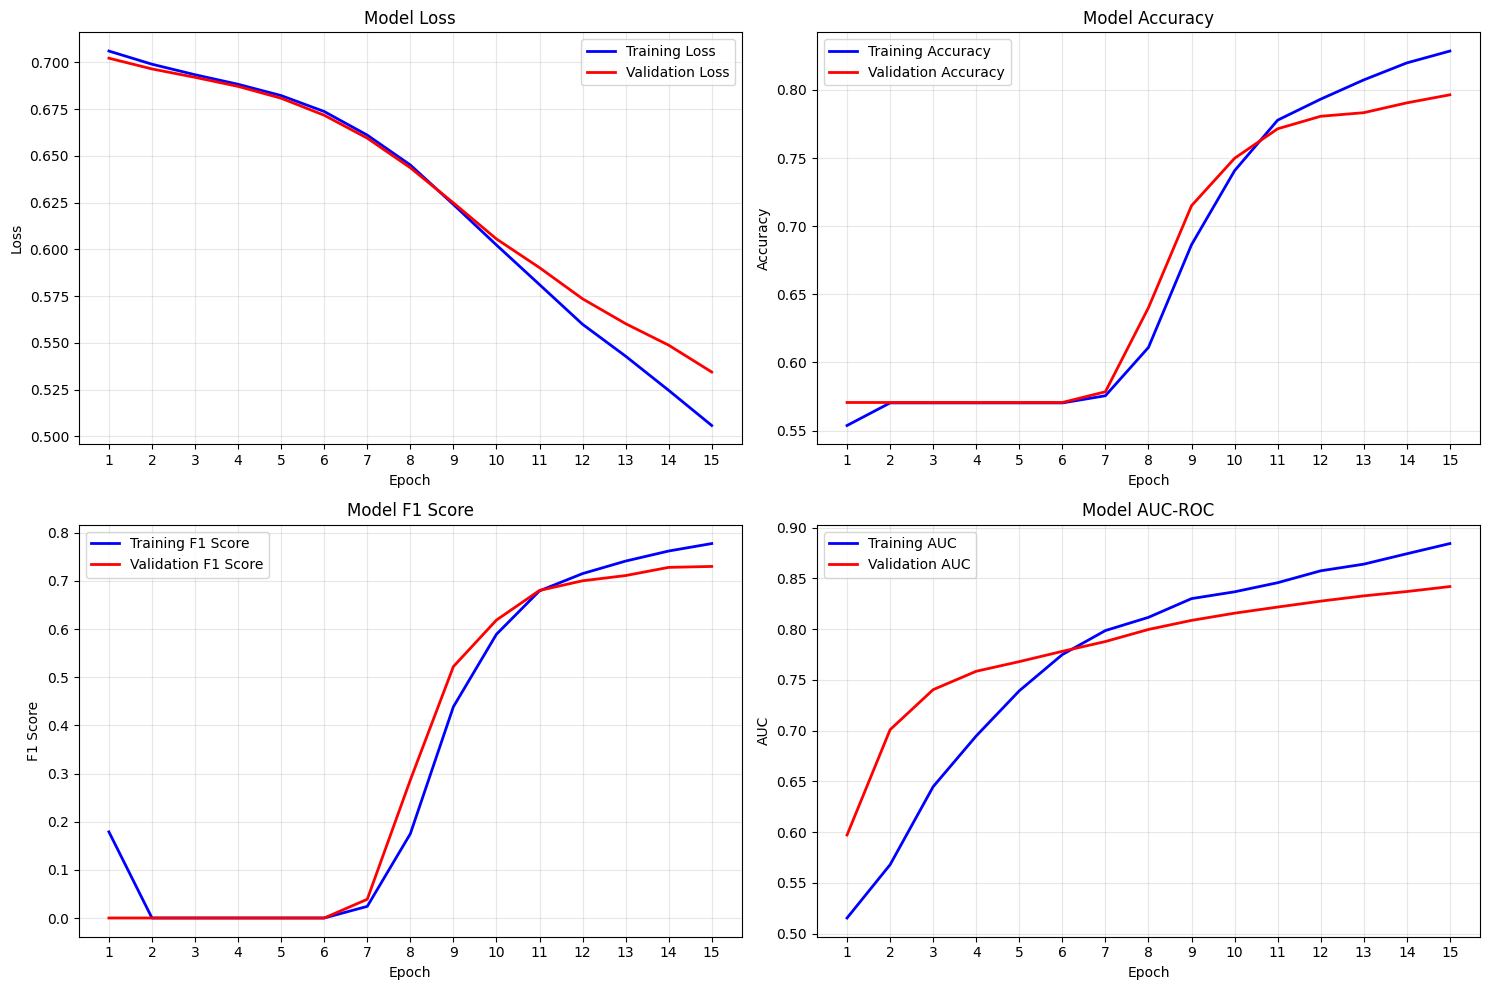

Learning Rate: 5e-05
Embedding Dimension: 64
Batch Size: 64

Results:
Loss: 0.5345
Accuracy: 0.7965
Training F1 Score: 0.7775
Validation F1 Score: 0.7300


In [60]:
LEARNING_RATE = 0.00005
EMB_DIM = 64
BATCH_SIZE = 64

blstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.0001), 
                       recurrent_regularizer=l2(0.0001))),

    Dense(1, activation='sigmoid')
])

hist_blstm = compile_fit(blstm, training_epochs=15, early_stopping=False)
plot_training_history(hist_blstm)

blstm_hists.append(hist_blstm)
blstm_models.append(blstm)

***
# Results and Conclusions
***

### Submission

Epoch 1/11
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5306 - Precision: 0.4481 - Recall: 0.1731 - accuracy: 0.5530 - loss: 0.7037 - val_AUC: 0.6712 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6977
Epoch 2/11
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - AUC: 0.5306 - Precision: 0.4481 - Recall: 0.1731 - accuracy: 0.5530 - loss: 0.7037 - val_AUC: 0.6712 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6977
Epoch 2/11
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.6157 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.6932 - val_AUC: 0.7254 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6894
Epoch 3/11
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 0.6157 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5703 - loss: 0.6932 - val_AUC: 0.7254 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.57

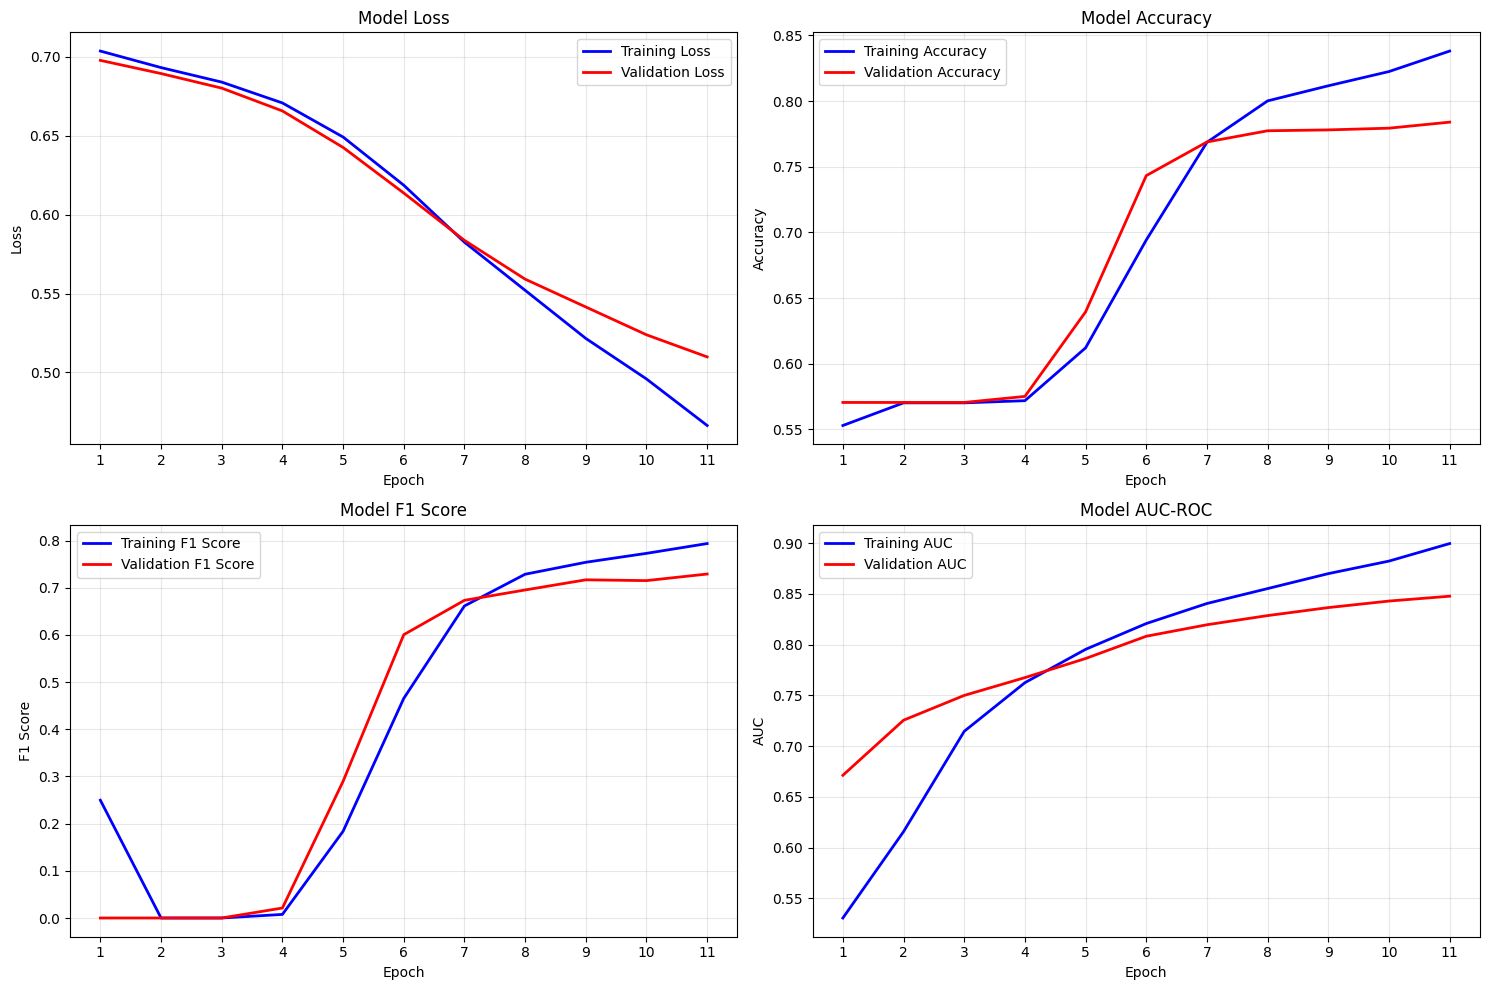

Learning Rate: 5e-05
Embedding Dimension: 64
Batch Size: 32

Results:
Loss: 0.5099
Accuracy: 0.7840
Training F1 Score: 0.7938
Validation F1 Score: 0.7292


In [69]:
LEARNING_RATE = 0.00005
EMB_DIM = 64
BATCH_SIZE = 32

blstm = Sequential([
    Embedding(vocab_size, EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    
    Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.0001), 
                       recurrent_regularizer=l2(0.0001))),

    Dense(1, activation='sigmoid')
])

hist_blstm = compile_fit(blstm, training_epochs=11, early_stopping=False)
plot_training_history(hist_blstm)

blstm_hists.append(hist_blstm)
blstm_models.append(blstm)

In [70]:
best_model = blstm
print(f"Model architecture:")
best_model.summary()

Model architecture:


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ (None, 50, 64)         │     1,416,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 32)             │        10,368 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,279,397 (16.32 MB)

 Trainable params: 1,426,465 (5.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,852,932 (10.88 MB)

In [71]:
pred_probs = best_model.predict(X_test_seq)
preds = (pred_probs > 0.5).astype(int).flatten()
test_data_original = pd.read_csv('./data/test.csv')
submission_df = pd.DataFrame({
    'id': test_data_original['id'],
    'target': preds
})
submission_df.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


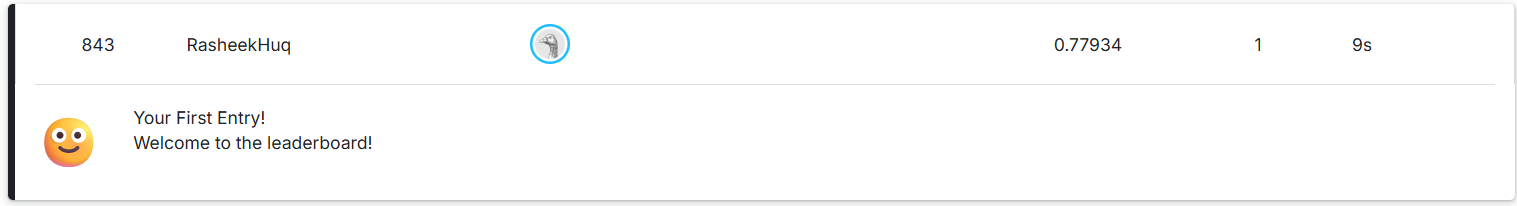

My final model ultimately got a decent f1-score of 0.779.

### Hyperparameter Tuning Summary

My procedure for tuning the hyperparameters involved tuning each individual parameter at a time, up and down. I optimized each one and moved to the next with the best versions of the model.

Some issues, such as the overfitting problem, had to be solved separately. Most of the hyperparameters were already optimal where they had started, so I moved to adjusting the architecture and the data preprocessing.

## Results

The final model had a very simple architecture, with a single Bidirectional LSTM layer and an output layer. This simple architecture likely performed better and did not overfit as much because the data itself was not very complex. Tweets are very short, averaging at about 15 words, with a max of 31 words in the training dataset.

The other final parameters were:
- learning rate of 0.00005
- batch size of 32
- embedding dimension of 64

Simplifying the architecture ended up bringing the biggest change, after changing the RNN type to LSTM/BiLSTM. Changing the dropout rates and L2 regularization also helped with overfitting.

This is not shown in this notebook, but I modified the data preprocessing step multiple times to help with overfitting, mainly the text cleaning function. I realized at some point that I was cleaning the text too agressively, potentially losing important information. After adjusting it, I also optimized the tokenizer, which helped model performance noticeably.

Many of the parameters were already optimal as they were, so tuning them did not have much of a positive effect. This may have just been coincidence that my parameters were close to optimal for my model. The architecture and data cleaning were more important.

## Conclusions

Through this project, I learned some of the frustration of not being able to improve my model through hyperparameter tuning. Most of my changes made little effect, which was likely caused by not making the right adjustments. After realizing what would actually make a difference, the model's performance improved a little more noticeably.

If I had more time, I could perform a more sytematic grid search of different combinations of hyperparameters, which would be more accurate in finding the right combination of settings.

This project used RNNs built from scratch, but I could also use more complex tokenizers like GloVe, and better pretrained RNNs like Bert.

### References

> 1. Culliton, Phil. “NLP Getting Started Tutorial.” Kaggle, Kaggle, 20 Dec. 2019, www.kaggle.com/code/philculliton/nlp-getting-started-tutorial. 

> 2. Evitan, Gunes. “NLP with Disaster Tweets - Eda, Cleaning and Bert.” Kaggle, Kaggle, 4 Feb. 2020, www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert. 

> 3. Audevart, Alexia. “Kerasnlp Starter Notebook Disaster Tweets.” Kaggle, Kaggle, 2 Aug. 2023, www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets/notebook. 

*AI Use/Citation:*

Github Copilot (Claude) was used during the development of this project. It's use was limited to:
- syntax correction/improvement
- code suggestions for small operations
- improving formatting of code
- nicely formatting print statements and statistics
- suggesting certain functions for plots I was trying to make
- making plots look and scale better

All ideas for every step of the project came from me.